In [1]:
cd /global/homes/p/pr4santh/Projects/SYMBA_SSM

/global/u1/p/pr4santh/Projects/SYMBA_SSM


# Data

In [2]:
path = '/pscratch/sd/p/pr4santh/Data/permutation_free'

In [3]:
import os

ls = os.listdir(path)

In [4]:
datasets = [_ for _ in ls if os.path.isdir(os.path.join(path, _)) and not _ == 'text_dump']

In [5]:
datasets

['QED-2-to-2',
 'sinekan',
 'EW-2-to-3',
 'QED-2-to-3',
 'EW-2-to-2',
 'QED-2-to-4',
 'QCD-2-to-2',
 'QCD-2-to-3',
 'QCD-2-to-4']

# Tokenizer

In [6]:
# Special token indices
BOS_IDX = 0  # Beginning of Sequence
PAD_IDX = 1  # Padding
EOS_IDX = 2  # End of Sequence
UNK_IDX = 3  # Unknown Token
SEP_IDX = 4  # Separator Token

T_IDX = [i for i in range(5,25)]


# Special token symbols
SPL_TERM_SYMBOLS = [f'<T{i}>' for i in range(20)]
SPECIAL_SYMBOLS = ['<BOS>', '<PAD>', '<EOS>', '<UNK>', '<SEP>'] + SPL_TERM_SYMBOLS


In [7]:
from tokenizer import Tokenizer, Vocab

In [8]:
def create_tokenizer(df, index_pool_size, to_replace):
    """Creates a tokenizer and builds source and target vocabularies.

    Args:
        df (pd.DataFrame): Dataset containing text samples.
        config (object): Configuration object.
        index_pool_size (int): Size of the index pool.
        momentum_pool_size (int): Size of the momentum pool.

    Returns:
        tuple: Tokenizer object, source vocab, target vocab, source index-to-string, target index-to-string.
    """
    tokenizer = Tokenizer(df, index_pool_size, SPECIAL_SYMBOLS, UNK_IDX, to_replace)
    src_vocab = tokenizer.build_src_vocab()
    tgt_vocab = tokenizer.build_tgt_vocab()
    src_vocab = Vocab(src_vocab, SPECIAL_SYMBOLS, BOS_IDX, PAD_IDX, EOS_IDX, UNK_IDX, SEP_IDX, T_IDX)
    tgt_vocab = Vocab(tgt_vocab, SPECIAL_SYMBOLS, BOS_IDX, PAD_IDX, EOS_IDX, UNK_IDX, SEP_IDX, T_IDX)
    return tokenizer, src_vocab, tgt_vocab


In [ ]:
import pandas as pd
def get_df_stats(dataset_name):
    dataset_path = os.path.join(path, dataset_name)
    df_train = pd.read_csv(os.path.join(dataset_path,'train.csv'))
    df_valid = pd.read_csv(os.path.join(dataset_path,'valid.csv'))
    df_test = pd.read_csv(os.path.join(dataset_path,'test.csv'))

    print('Loaded Dataset')
    df = pd.concat([df_train, df_valid, df_test]).reset_index(drop=True)

    tokenizer, src_vocab, tgt_vocab = create_tokenizer(df, index_pool_size=150, to_replace=False)

    # src_vocab
    src_voc_size = len(src_vocab)
    tgt_voc_size = len(tgt_vocab)


    return src_voc_size, tgt_voc_size, tokenizer, src_vocab, tgt_vocab, df_train, df_valid, df_test

In [10]:
dataset_name = 'QED-2-to-4'
dataset_path = os.path.join(path, dataset_name)
df_train = pd.read_csv(os.path.join(dataset_path,'train.csv'))
df_valid = pd.read_csv(os.path.join(dataset_path,'valid.csv'))
df_test = pd.read_csv(os.path.join(dataset_path,'test.csv'))

print('Loaded Dataset')


# return src_voc_size, tgt_voc_size, tokenizer, src_vocab, tgt_vocab, df_train, df_valid, df_test

Loaded Dataset


In [13]:
df_train['amp'].iloc[0]

' -i*e^2*(p_1_%\\nu_28037*gamma_{%\\mu_27603,%eta_9617,%eps_7326}*A_{l_10695,+%\\mu_27603}(p_2)*A_{j_10697,+%\\nu_28037}(p_4)^(*)*mu_{i_10697,%eps_7326}(p_3)_v*mu_{k_10695,%eta_9617}(p_1)_v^(*) + -1/2*p_4_%\\tau_27567*gamma_{%\\mu_27603,%eta_9638,%eps_7328}*gamma_{%\\nu_28037,%eta_9620,%eta_9637}*gamma_{+%\\tau_27567,%eta_9637,%eta_9638}*A_{l_10695,+%\\mu_27603}(p_2)*A_{j_10697,+%\\nu_28037}(p_4)^(*)*mu_{i_10697,%eps_7328}(p_3)_v*mu_{k_10695,%eta_9620}(p_1)_v^(*))/(s_23 + -1/2*reg_prop) '

In [ ]:
df = pd.concat([df_train, df_valid, df_test]).reset_index(drop=True)

tokenizer, src_vocab, tgt_vocab = create_tokenizer(df, index_pool_size=1024, to_replace=True)

# src_vocab
src_voc_size = len(src_vocab)
tgt_voc_size = len(tgt_vocab)


Processing target vocab: 100%|██████████| 20762/20762 [01:15<00:00, 273.36it/s]


In [23]:
len(src_vocab.token_to_idx)

261

# Anal yse

In [11]:
print(datasets)

['QED-2-to-2', 'sinekan', 'EW-2-to-3', 'QED-2-to-3', 'EW-2-to-2', 'QED-2-to-4', 'QCD-2-to-2', 'QCD-2-to-3', 'QCD-2-to-4']


In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_length_dist(dataset_type, src_voc_size, tgt_voc_size, tokenizer, src_vocab, tgt_vocab, df_train, df_valid, df_test):
    # dataset_type = datasets[data_idx]
    # print(f"Dataset: {dataset_type}")

    # # Load dataset and tokenizer
    # src_voc_size, tgt_voc_size, tokenizer, src_vocab, tgt_vocab, df_train, df_valid, df_test = get_df_stats(dataset_type)

    # Prepare big figure
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))  # 2 rows, 2 columns

    for row_idx, (name, df) in enumerate([('train', df_train), ('valid', df_valid)]):
        print(f'\nProcessing split: {name}')

        # Tokenize and compute lengths
        df['sqamp_tokens'] = df['sqamp'].apply(tokenizer.tgt_tokenize)
        df['amp_tokens'] = df['amp'].apply(tokenizer.src_tokenize)

        df['sqamp_len'] = df['sqamp_tokens'].apply(len)
        df['amp_len'] = df['amp_tokens'].apply(len)

        # sqamp length plot
        sns.histplot(df['sqamp_len'], bins=50, kde=False, ax=axes[row_idx, 0])
        axes[row_idx, 0].set_title(f'{name} - sqamp token lengths')
        axes[row_idx, 0].set_xlabel('Length')
        axes[row_idx, 0].set_ylabel('Count')

        # amp length plot
        sns.histplot(df['amp_len'], bins=50, kde=False, ax=axes[row_idx, 1])
        axes[row_idx, 1].set_title(f'{name} - amp token lengths')
        axes[row_idx, 1].set_xlabel('Length')
        axes[row_idx, 1].set_ylabel('Count')

    fig.suptitle(f"Distribution of Token Lengths - {dataset_type}", fontsize=18, fontweight='bold')

    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space for the suptitle
    plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def get_cum_dist(dataset_type, src_voc_size, tgt_voc_size, tokenizer, src_vocab, tgt_vocab, df_train, df_valid, df_test):


    # Prepare single large figure (2 rows: train/valid, 2 cols: sqamp/amp)
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))

    for row_idx, (name, df) in enumerate([('train', df_train), ('valid', df_valid)]):
        print(f'\nProcessing split: {name}')

        # Tokenize and compute lengths
        df['sqamp_tokens'] = df['sqamp'].apply(tokenizer.tgt_tokenize)
        df['amp_tokens'] = df['amp'].apply(tokenizer.src_tokenize)

        df['sqamp_len'] = df['sqamp_tokens'].apply(len)
        df['amp_len'] = df['amp_tokens'].apply(len)

        for col_idx, (col, label) in enumerate([('sqamp_len', 'sqamp'), ('amp_len', 'amp')]):
            ax = axes[row_idx, col_idx]
            lengths = df[col].values
            sorted_lengths = np.sort(lengths)

            # Plot ECDF
            sns.ecdfplot(lengths, ax=ax)
            ax.set_title(f'{name} - CDF of {label} token lengths')
            ax.set_xlabel('Length')
            ax.set_ylabel('Cumulative Probability')

            # ---- Mark powers of 2 ----
            powers_of_two = [2**i for i in range(1, int(np.log2(sorted_lengths.max())) + 1)]
            for p in powers_of_two:
                prob_at_p = np.mean(lengths <= p)
                ax.axvline(p, color='gray', linestyle='--', alpha=0.4)
                ax.scatter(p, prob_at_p, color='red', zorder=5)
                ax.text(p, prob_at_p + 0.02, f'({p}, {prob_at_p:.2f})',
                        fontsize=8, ha='center', va='bottom', rotation=45)

            # ---- Mark specific quantiles ----
            quantiles = [0.10, 0.25, 0.50, 0.75]
            for q in quantiles:
                length_at_q = np.percentile(lengths, q * 100)
                ax.axhline(q, color='blue', linestyle=':', alpha=0.4)
                ax.scatter(length_at_q, q, color='green', zorder=5)
                ax.text(length_at_q, q - 0.04, f'({length_at_q:.0f}, {q:.2f})',
                        fontsize=8, ha='center', va='top', rotation=45)

    fig.suptitle(f"Cumulative Distribution of Token Lengths - {dataset_type}", fontsize=18, fontweight='bold')

    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space for the suptitle
    plt.show()


# QED

In [14]:
qed_ids = []
for i, d in enumerate(datasets):
    if 'QED' in d:
        qed_ids.append(i)

In [15]:
qed_ids

[0, 3, 5]

QED-2-to-2
Dataset: QED-2-to-2
Loaded Dataset


Processing target vocab: 100%|██████████| 360/360 [00:00<00:00, 19759.08it/s]


Processing split: train



Processing split: valid


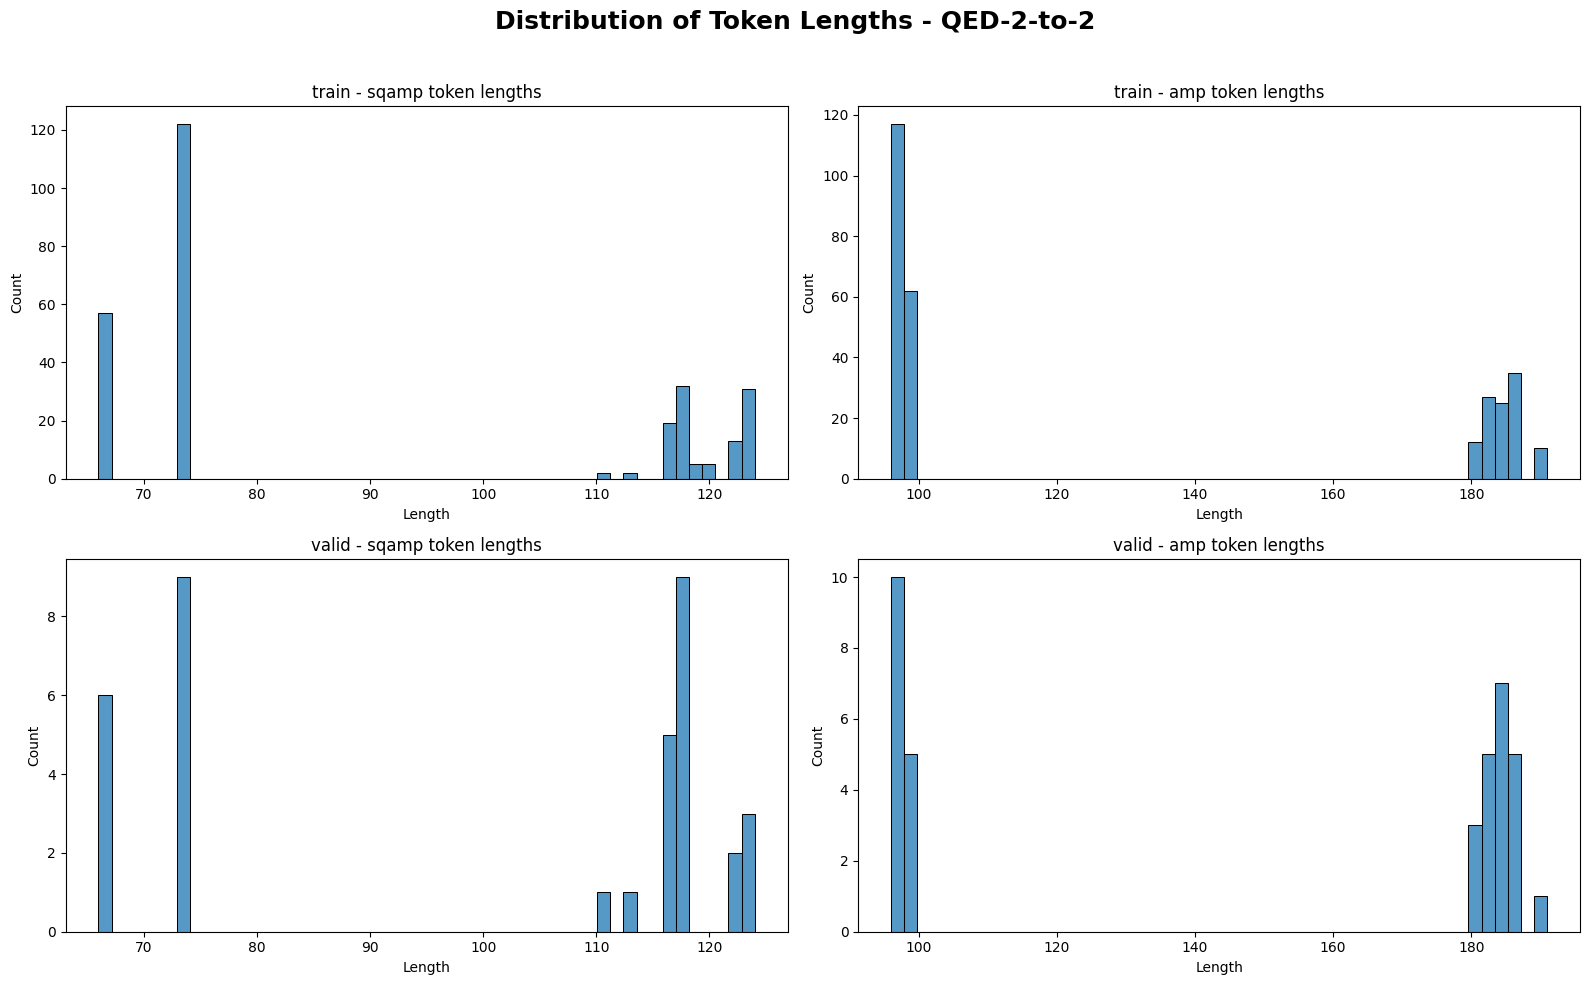

Dataset: QED-2-to-2
Loaded Dataset


Processing target vocab: 100%|██████████| 360/360 [00:00<00:00, 19661.57it/s]


Processing split: train



Processing split: valid


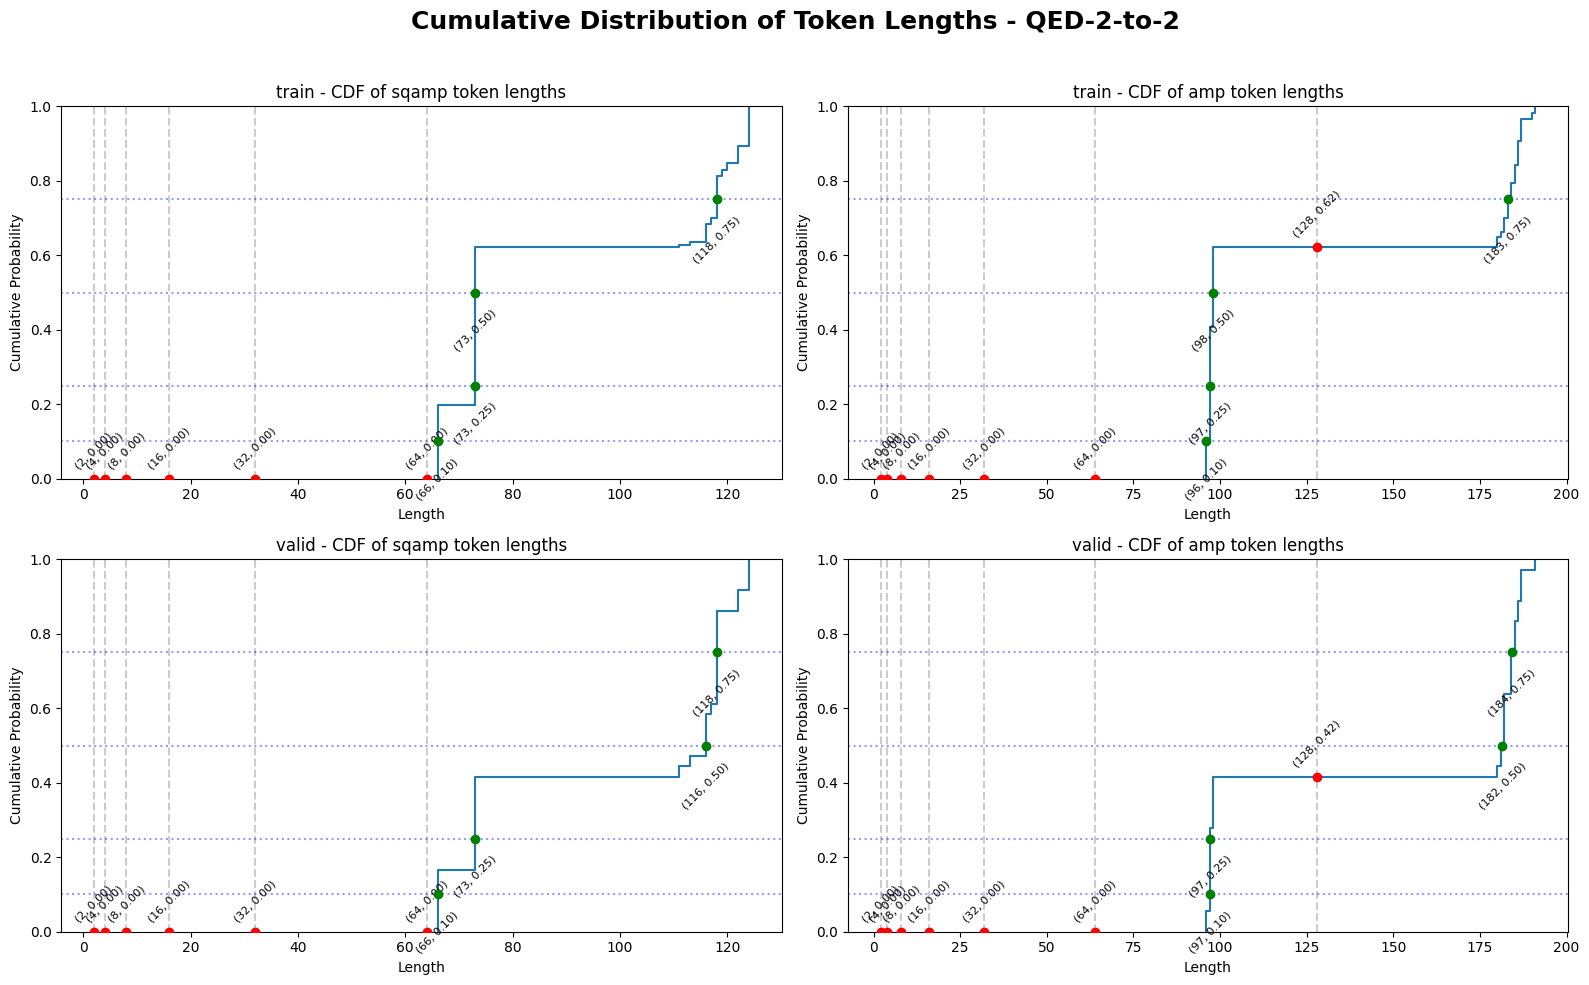

QED-2-to-3
Dataset: QED-2-to-3
Loaded Dataset


Processing target vocab: 100%|██████████| 3042/3042 [00:01<00:00, 2059.79it/s]



Processing split: train

Processing split: valid


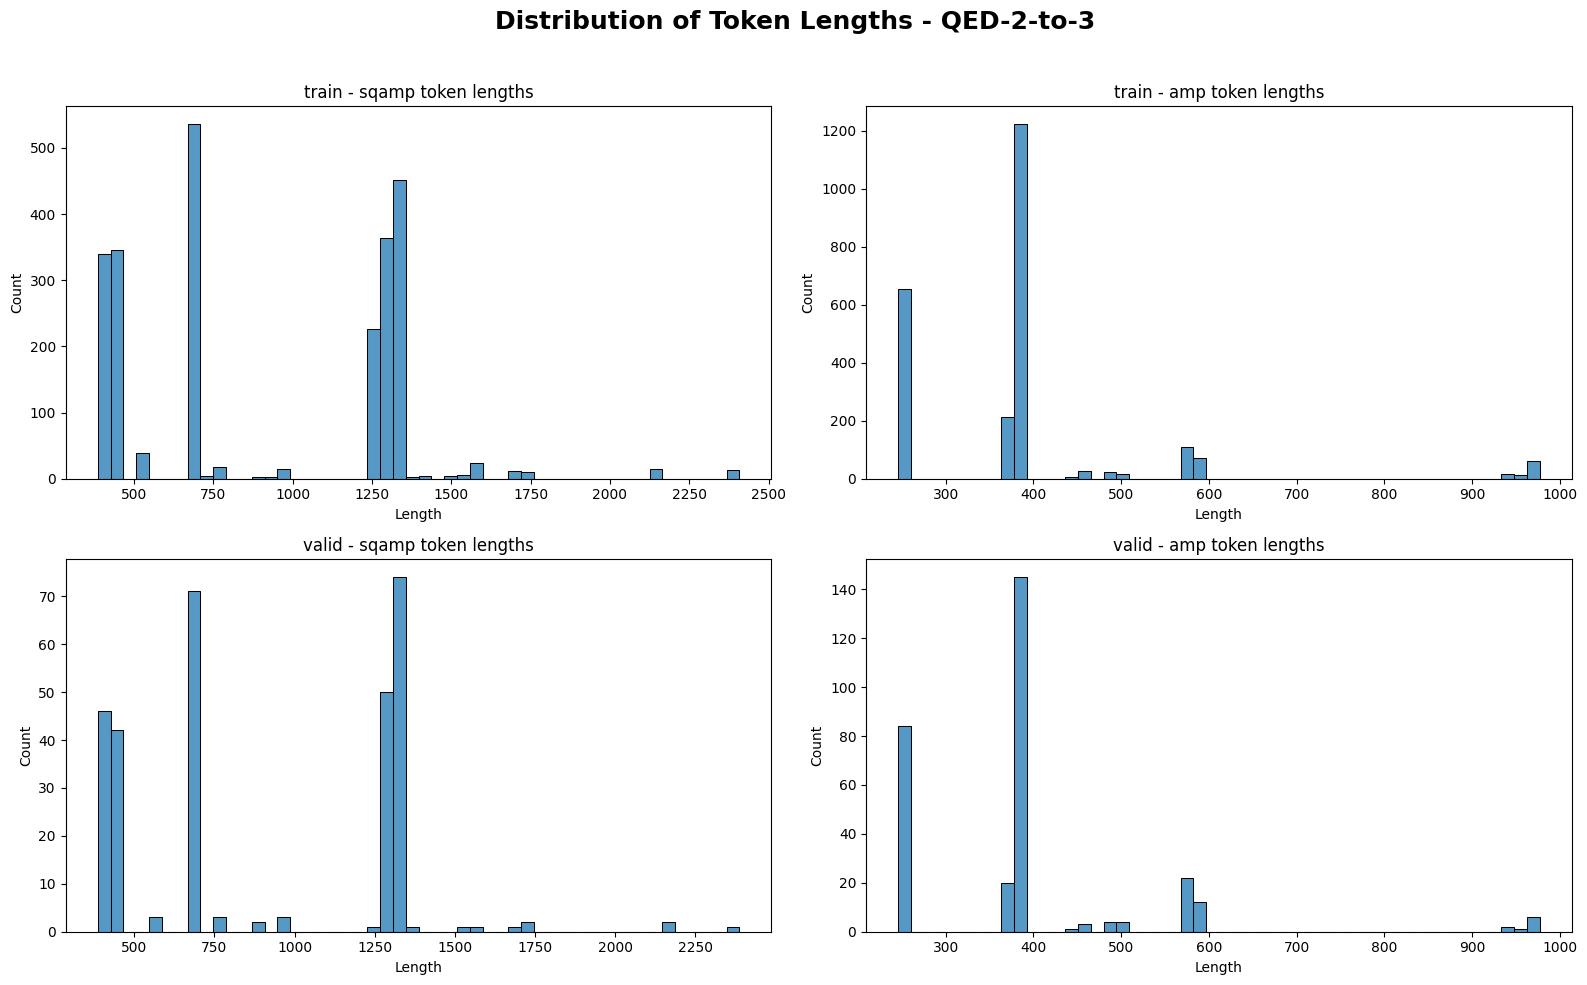

Dataset: QED-2-to-3
Loaded Dataset


Processing target vocab: 100%|██████████| 3042/3042 [00:01<00:00, 2105.64it/s]



Processing split: train

Processing split: valid


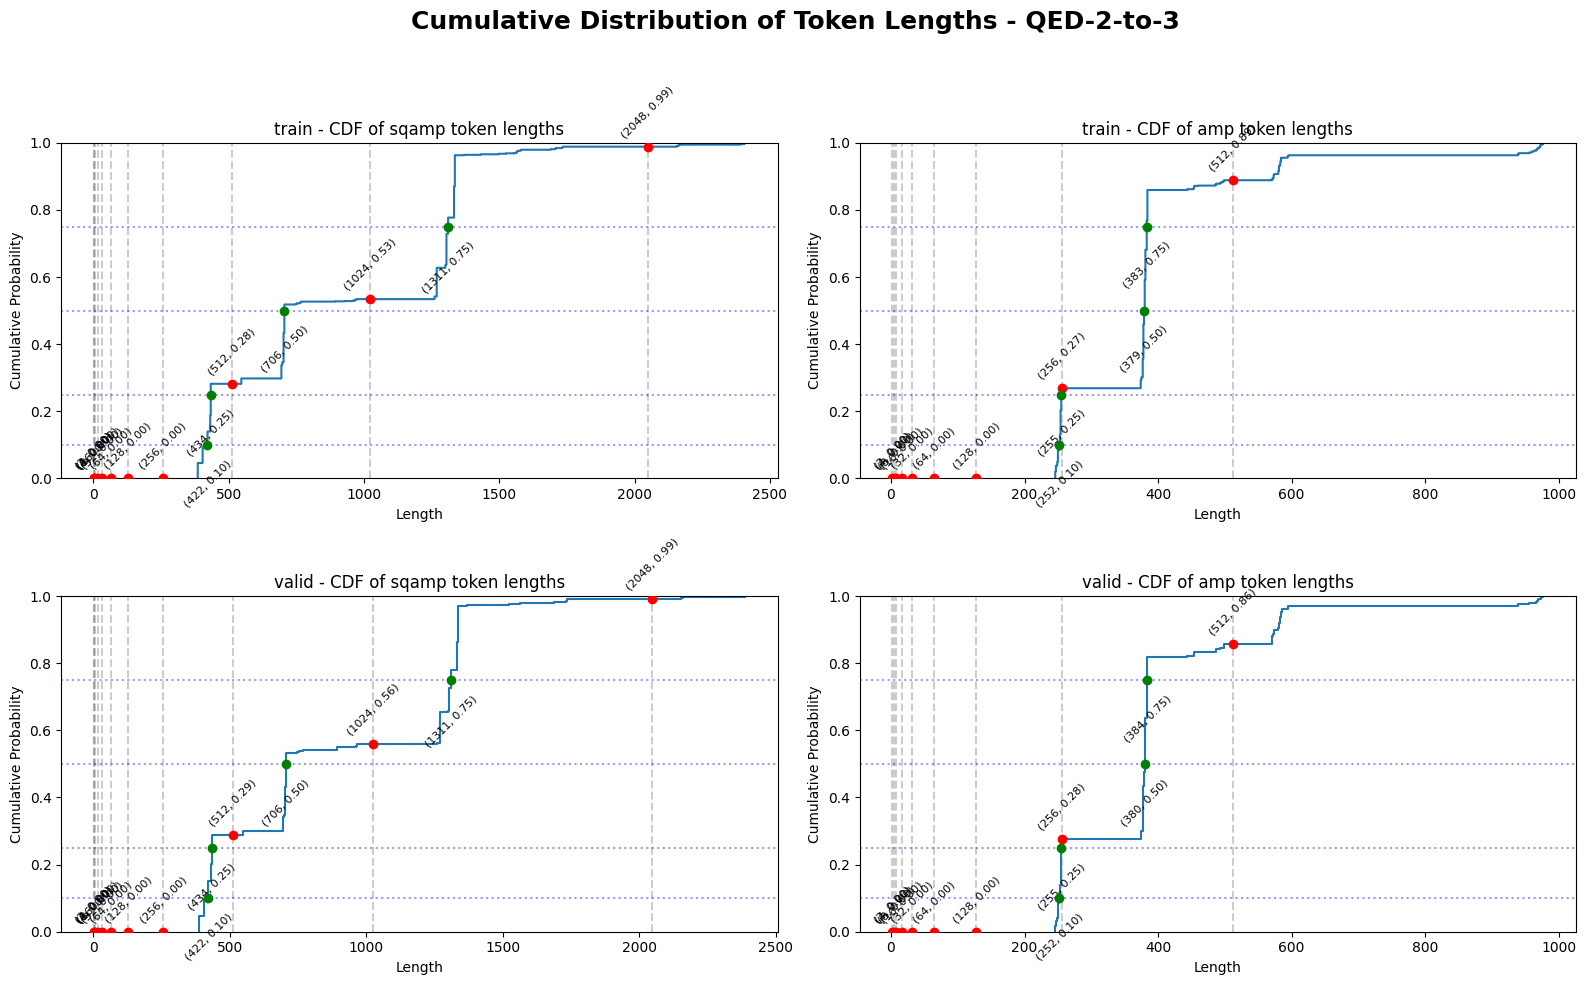

QED-2-to-4
Dataset: QED-2-to-4
Loaded Dataset


Processing target vocab: 100%|██████████| 20762/20762 [00:50<00:00, 411.95it/s]



Processing split: train

Processing split: valid


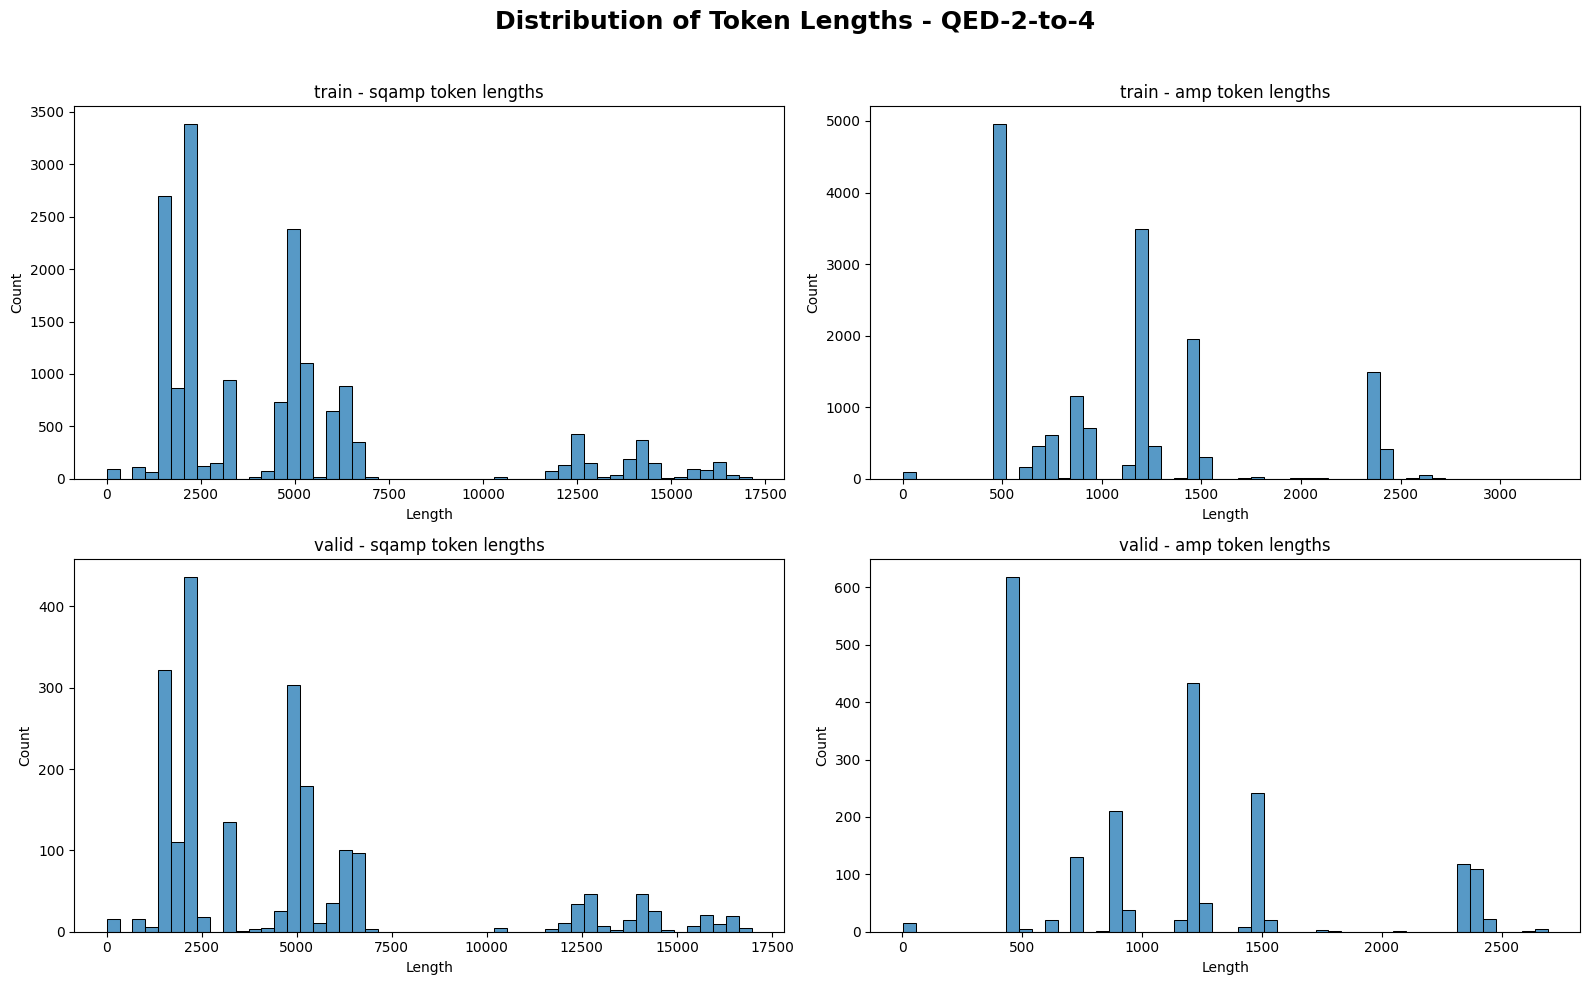

Dataset: QED-2-to-4
Loaded Dataset


Processing target vocab: 100%|██████████| 20762/20762 [00:50<00:00, 414.00it/s]



Processing split: train

Processing split: valid


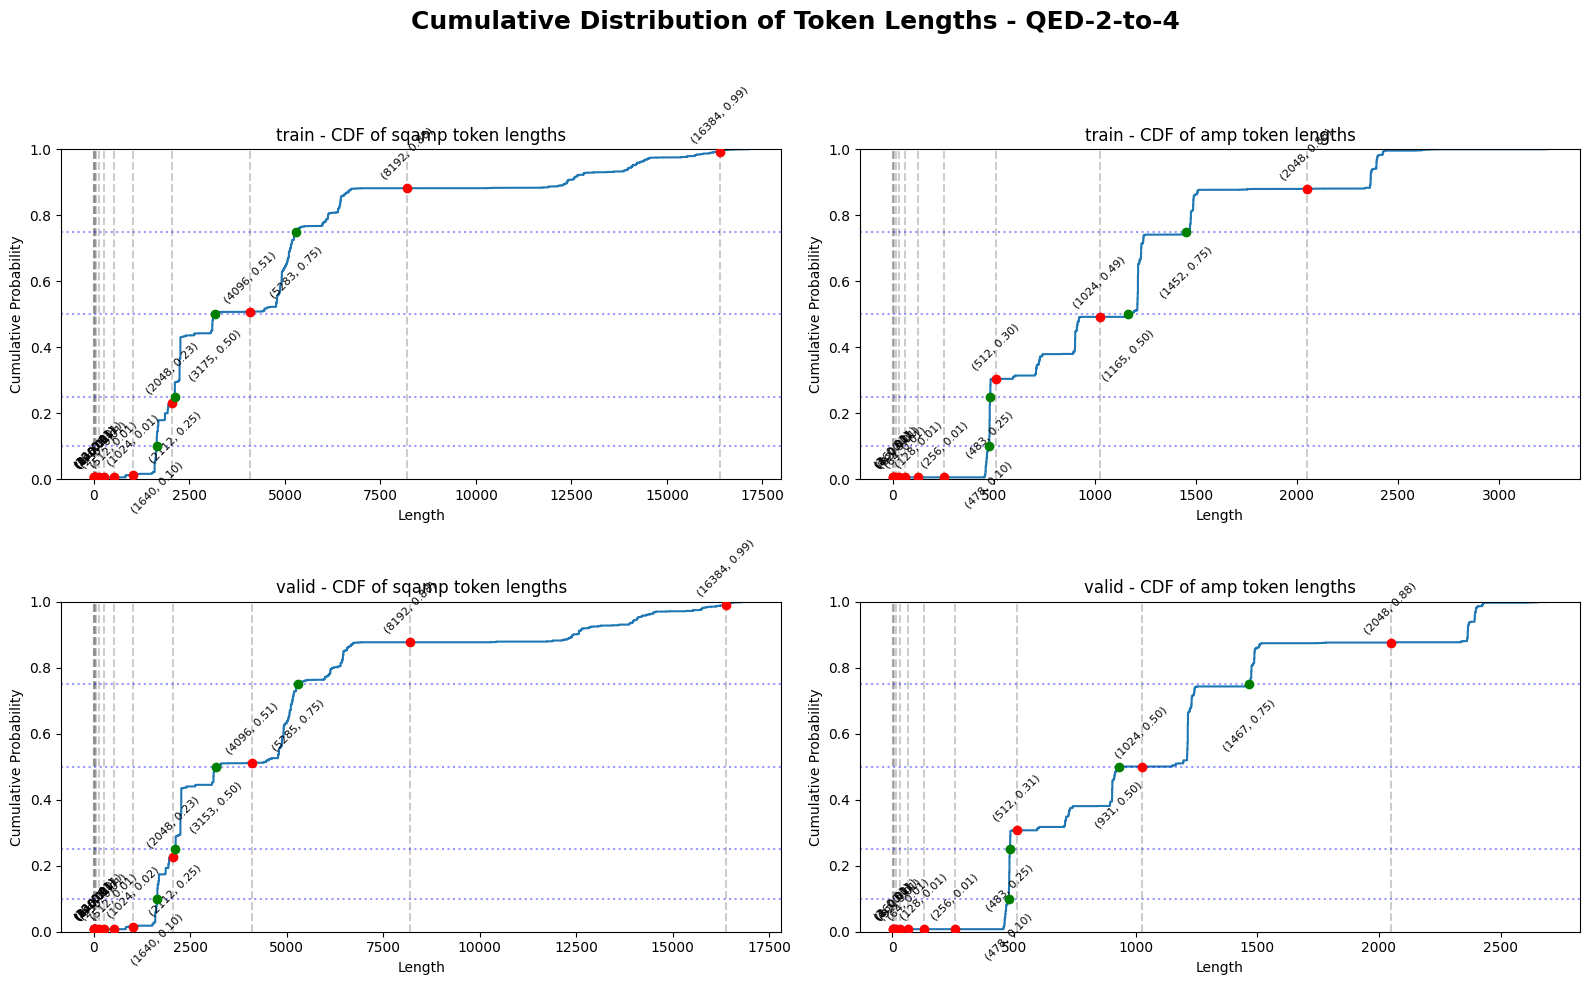

In [ ]:
for idx in qed_ids:
    print(datasets[idx])
    plot_length_dist(idx)
    get_cum_dist(idx)
    # break


# QCD

In [29]:
qcd_ids = []
for i,d  in enumerate(datasets):
    if 'QCD' in d:
        qcd_ids.append(i)

Dataset: QCD-2-to-2
Loaded Dataset


Processing target vocab: 100%|██████████| 234/234 [00:00<00:00, 4785.17it/s]



Processing split: train

Processing split: valid


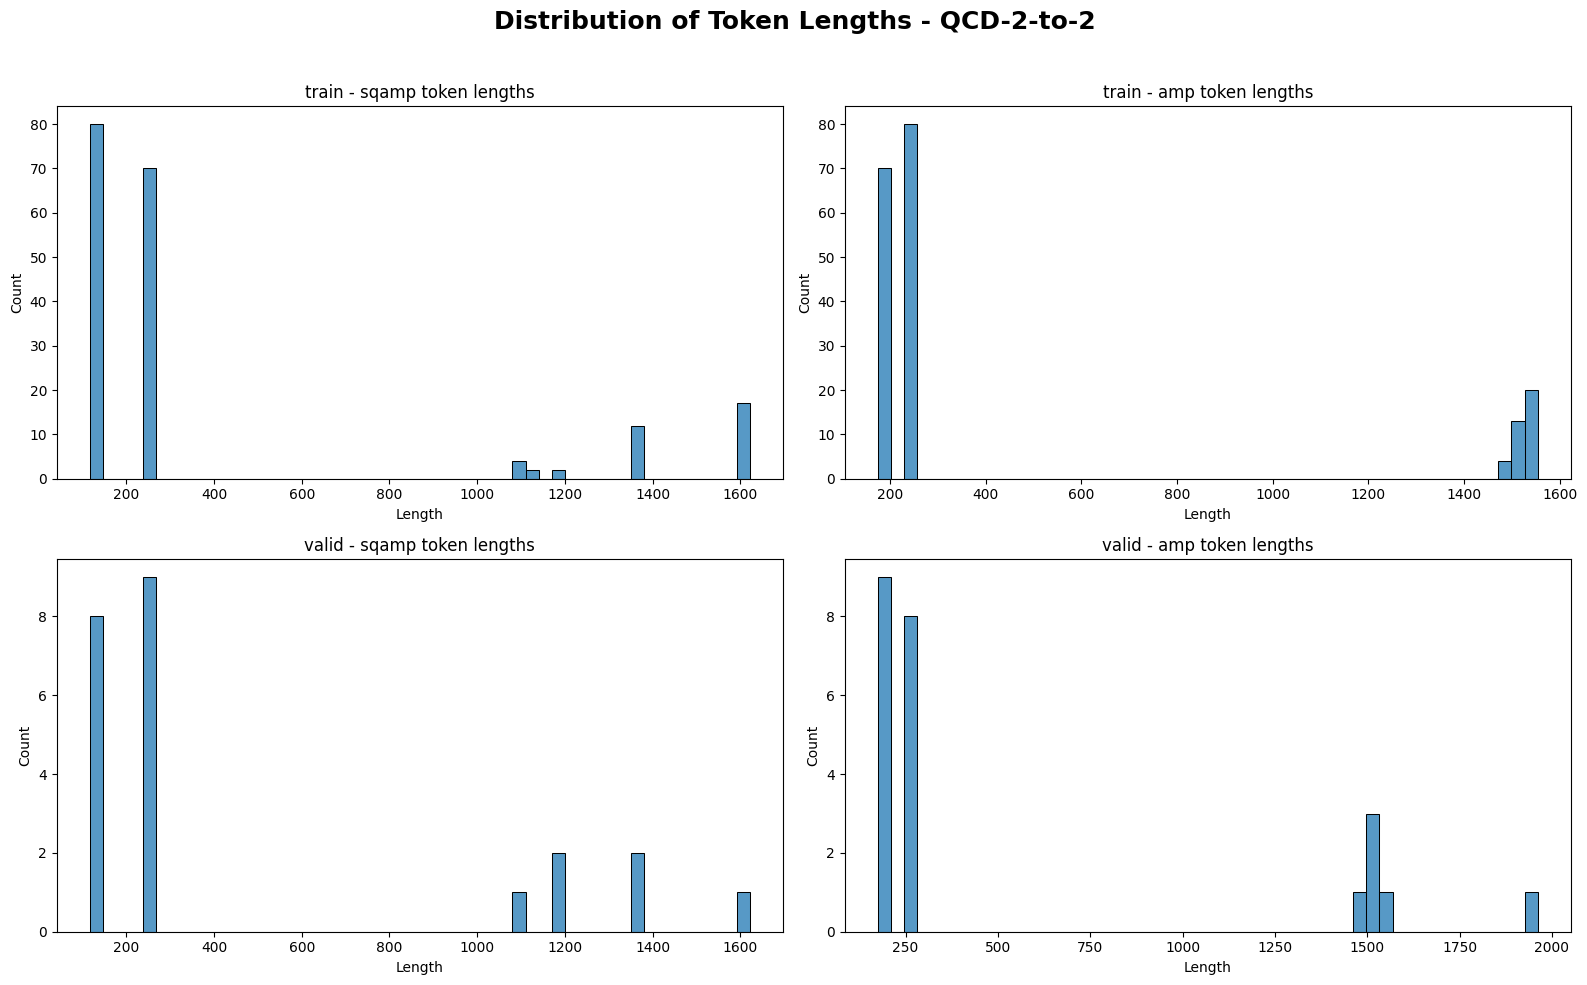


Processing split: train

Processing split: valid


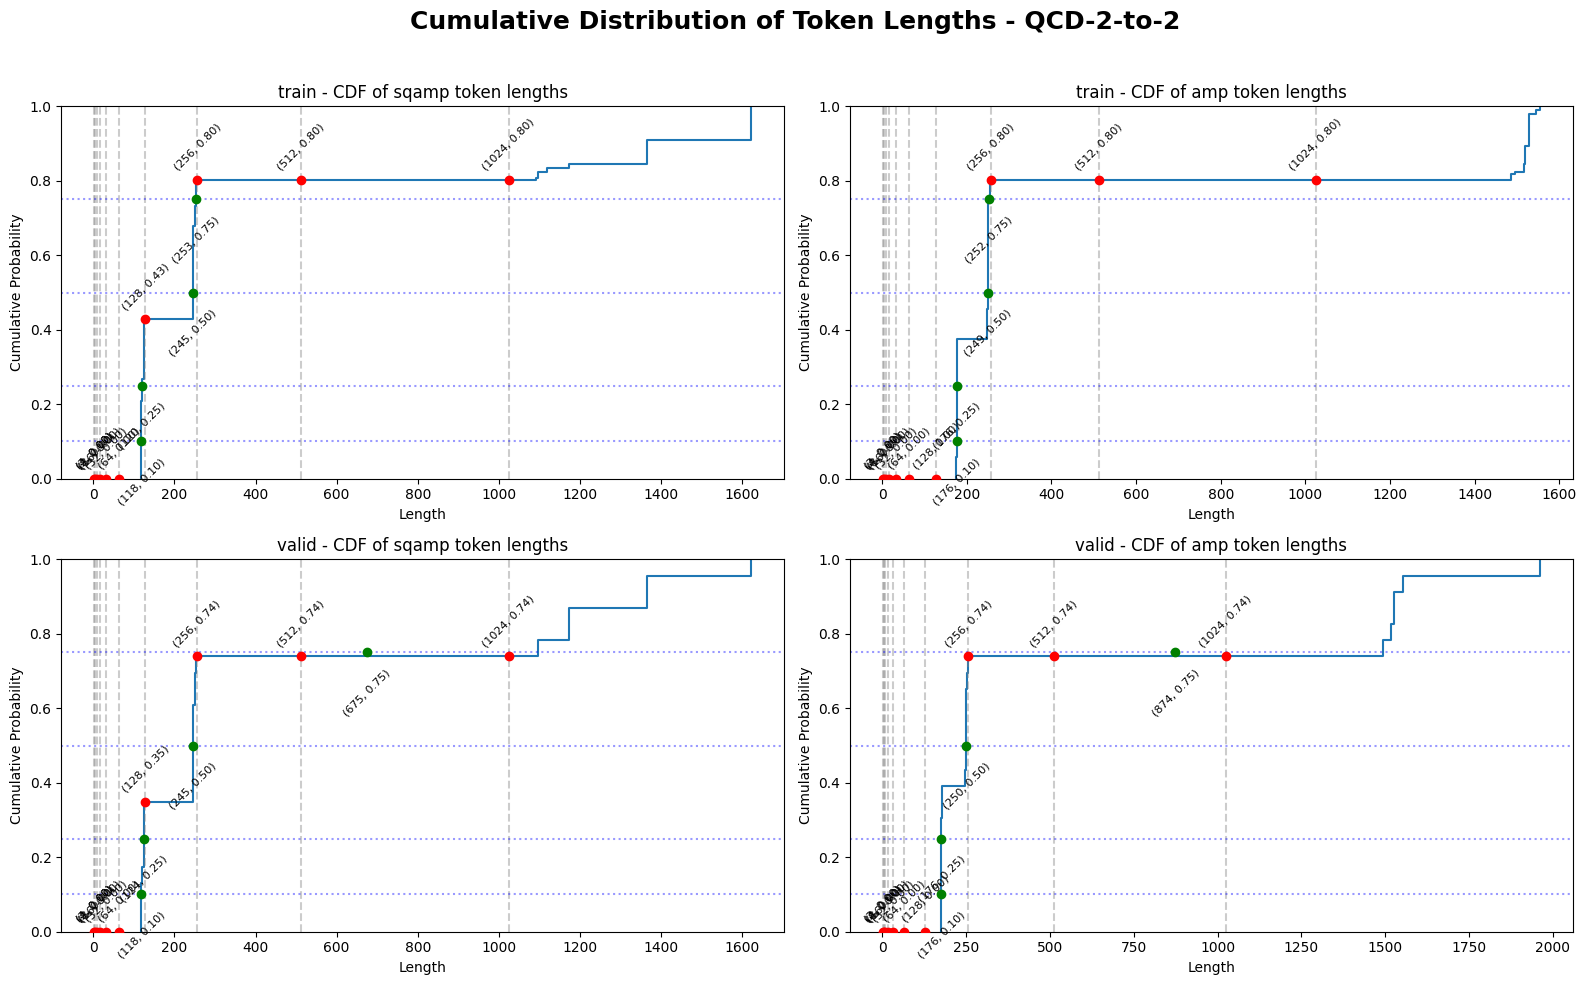

Dataset: QCD-2-to-3
Loaded Dataset


Processing target vocab: 100%|██████████| 1518/1518 [00:02<00:00, 638.95it/s]



Processing split: train

Processing split: valid


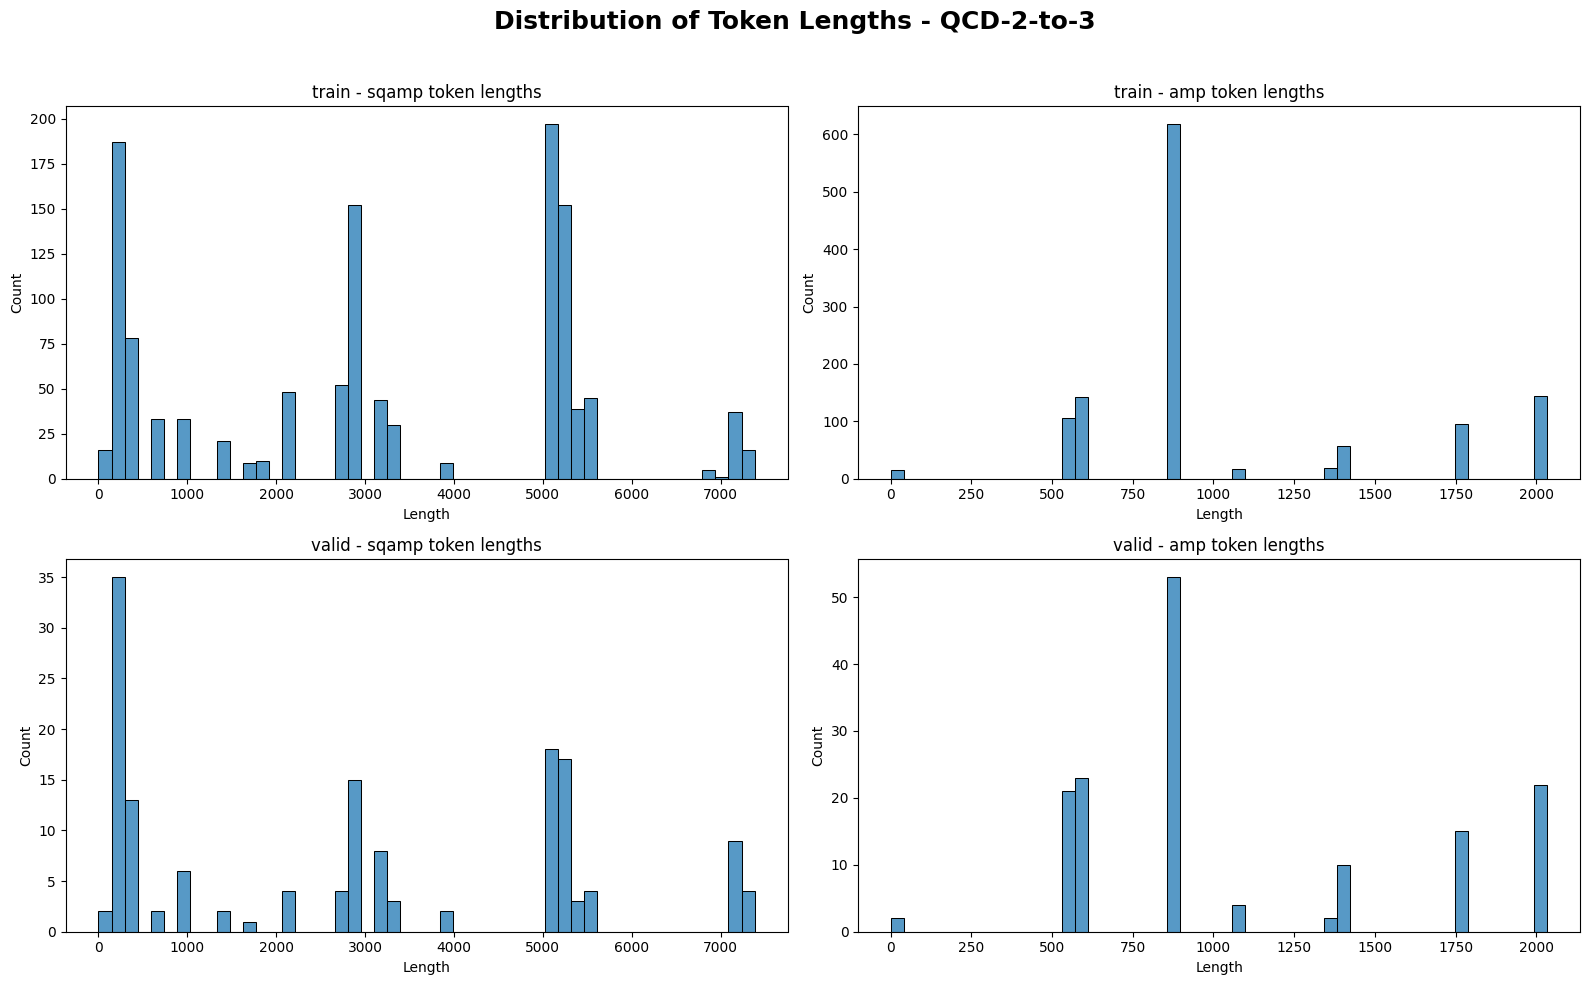


Processing split: train

Processing split: valid


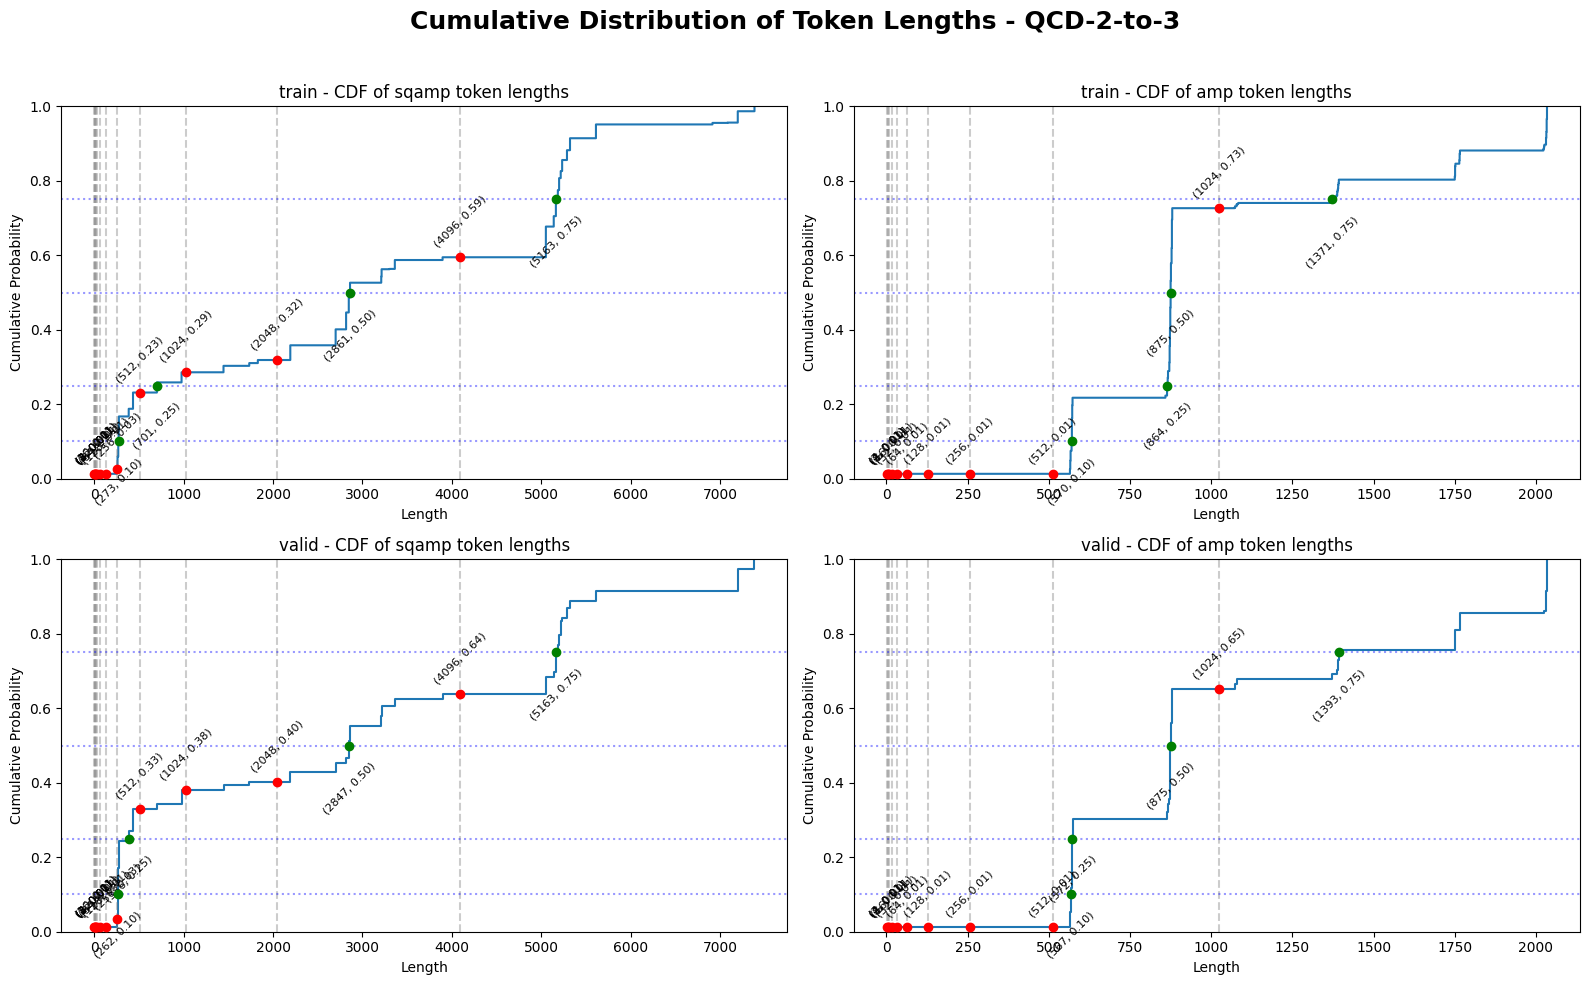

Dataset: QCD-2-to-4
Loaded Dataset


Processing target vocab: 100%|██████████| 2385/2385 [00:15<00:00, 156.01it/s]



Processing split: train

Processing split: valid


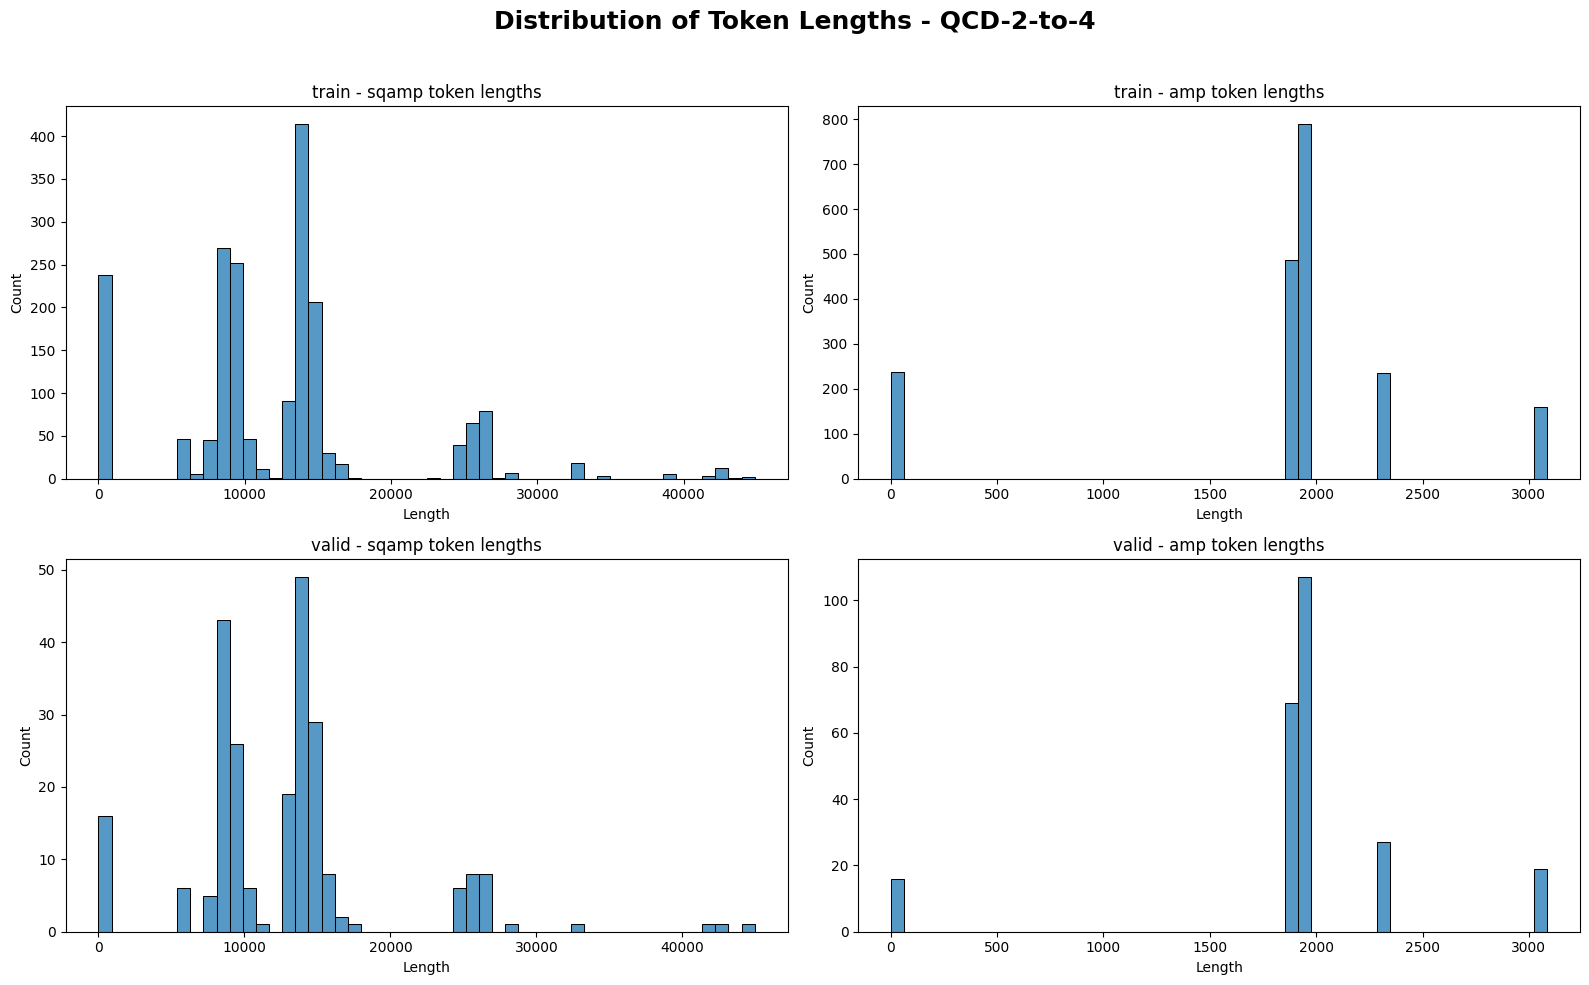


Processing split: train

Processing split: valid


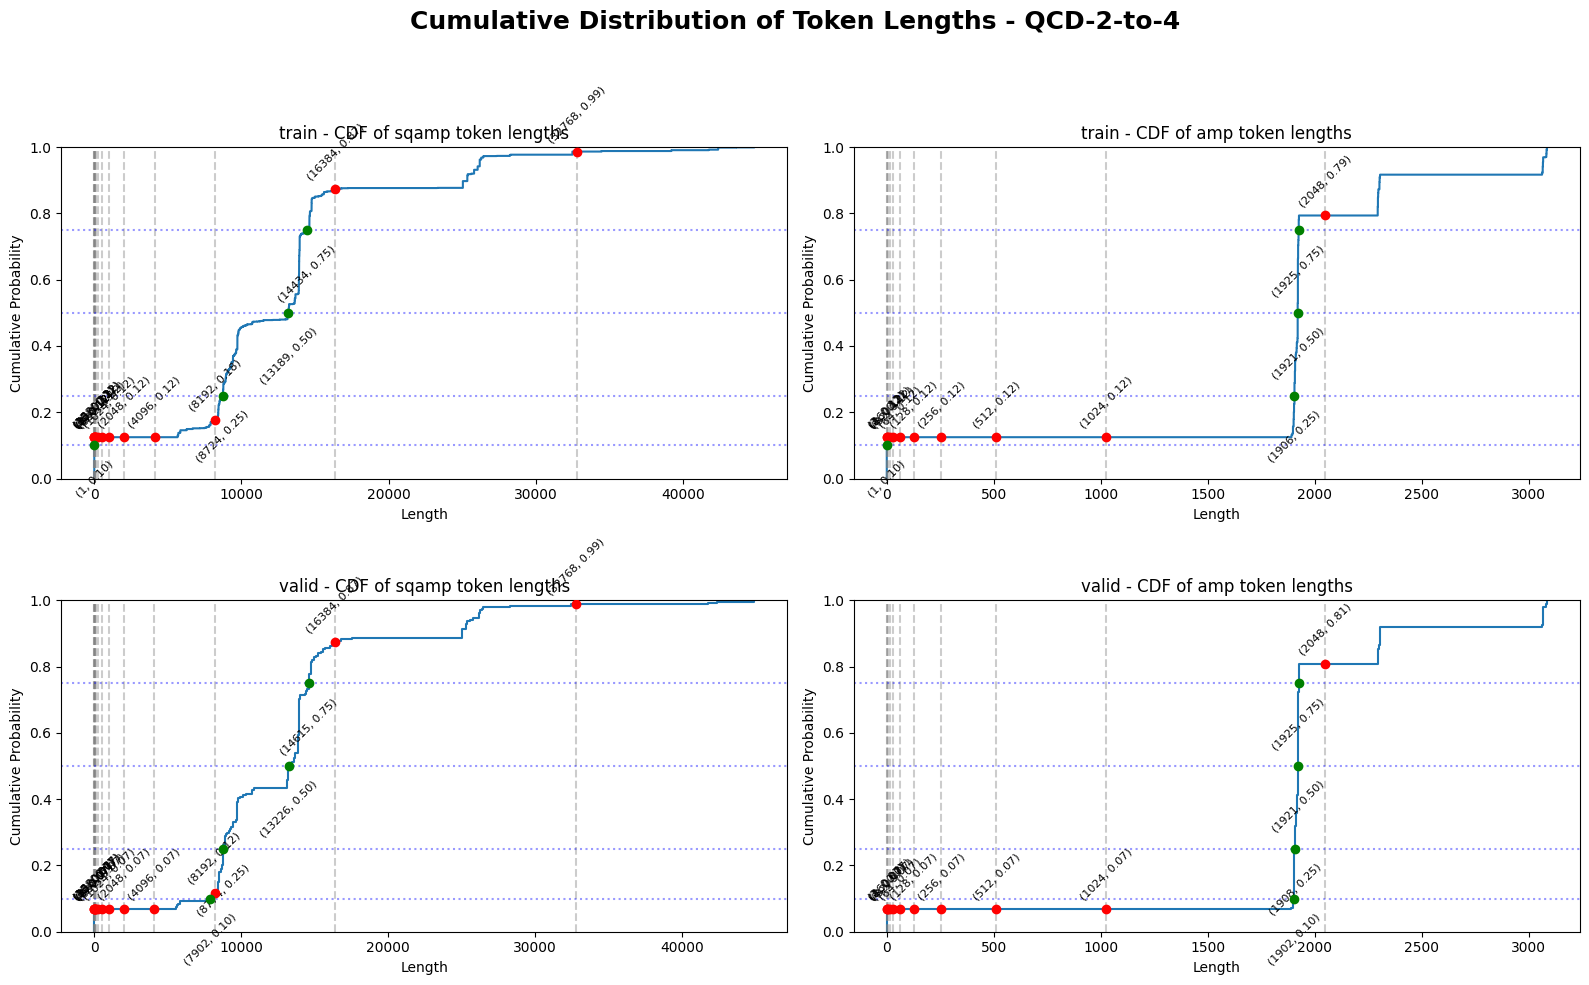

In [ ]:
for data_idx in qcd_ids:
    dataset_type = datasets[data_idx]
    print(f"Dataset: {dataset_type}")

    # Load dataset and tokenizer
    src_voc_size, tgt_voc_size, tokenizer, src_vocab, tgt_vocab, df_train, df_valid, df_test = get_df_stats(dataset_type)


    plot_length_dist(dataset_type, src_voc_size, tgt_voc_size, tokenizer, src_vocab, tgt_vocab, df_train, df_valid, df_test)
    get_cum_dist(dataset_type, src_voc_size, tgt_voc_size, tokenizer, src_vocab, tgt_vocab, df_train, df_valid, df_test)
    # break

# EW

In [10]:
ew_ids = []
for i,d  in enumerate(datasets):
    if 'EW' in d:
        ew_ids.append(i)

ew_ids

[2, 4]

Dataset: EW-2-to-3
Loaded Dataset


Processing target vocab: 100%|██████████| 110635/110635 [01:31<00:00, 1202.65it/s]



Processing split: train

Processing split: valid


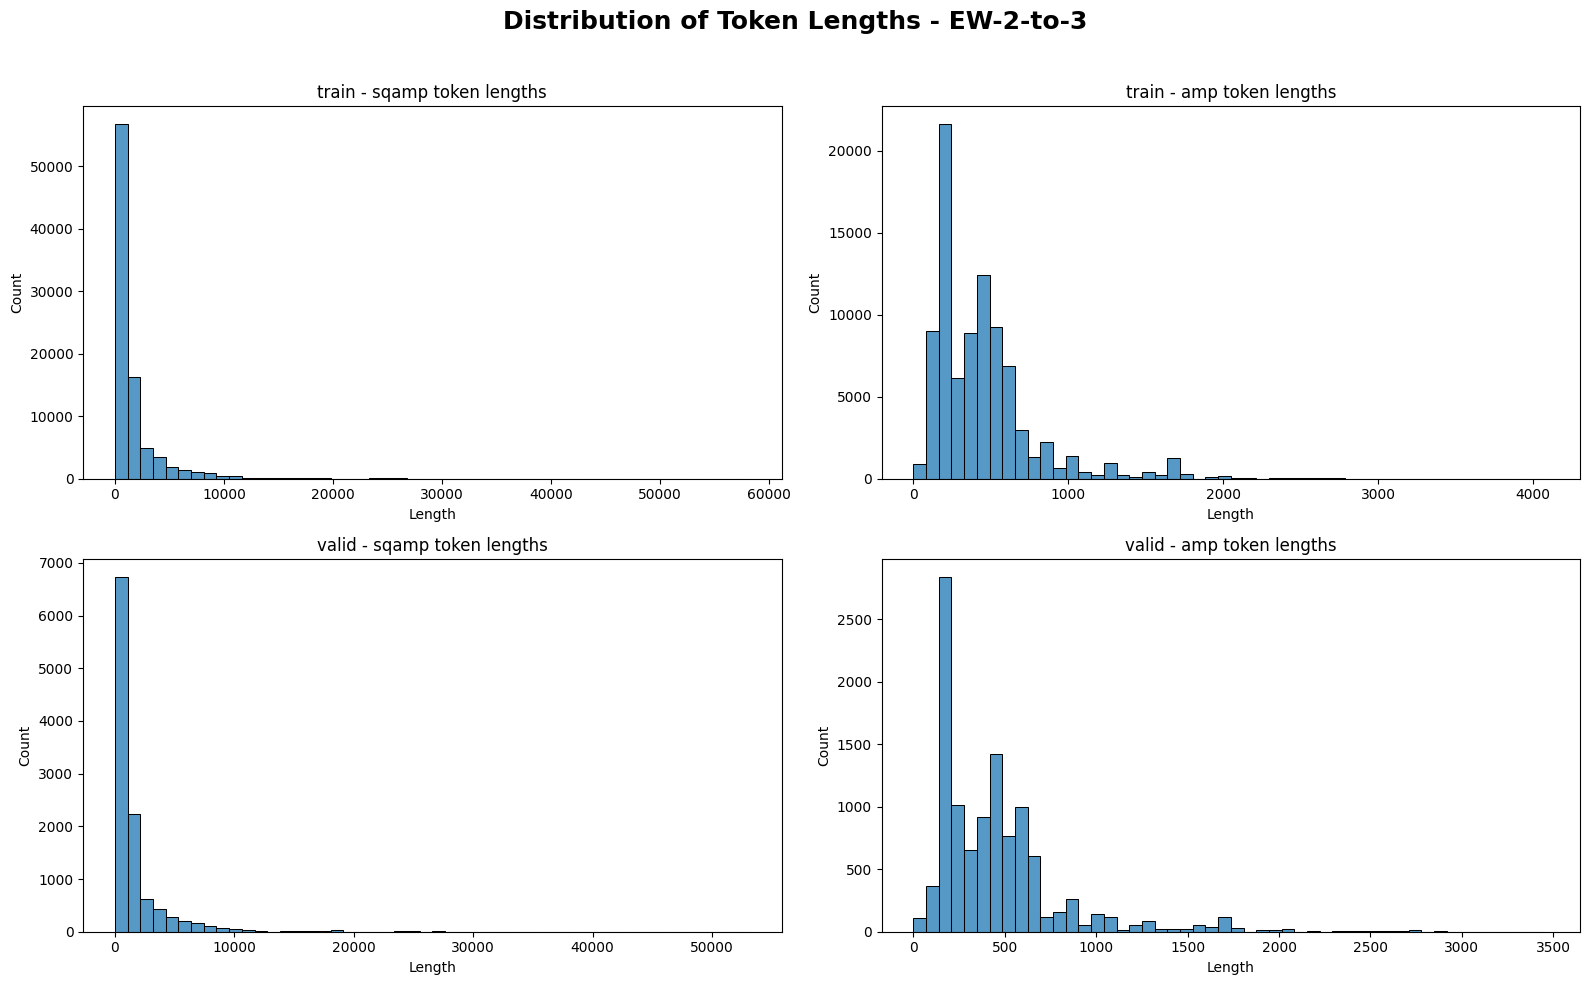


Processing split: train

Processing split: valid


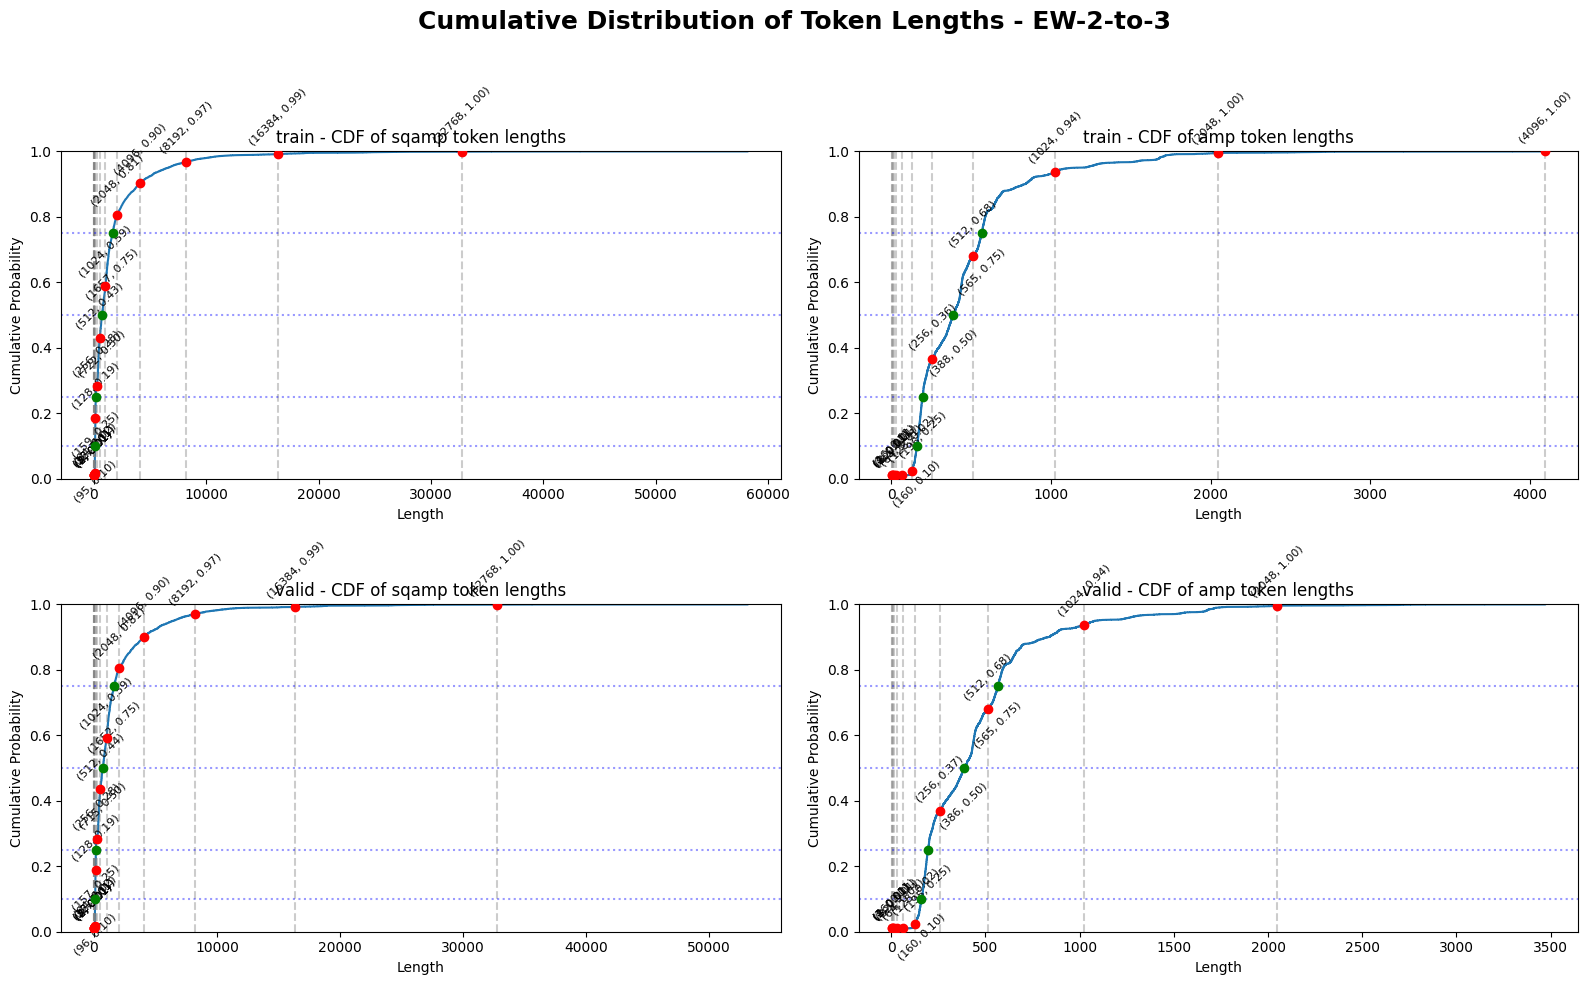

Dataset: EW-2-to-2
Loaded Dataset


Processing target vocab: 100%|██████████| 8512/8512 [00:02<00:00, 3832.02it/s]



Processing split: train

Processing split: valid


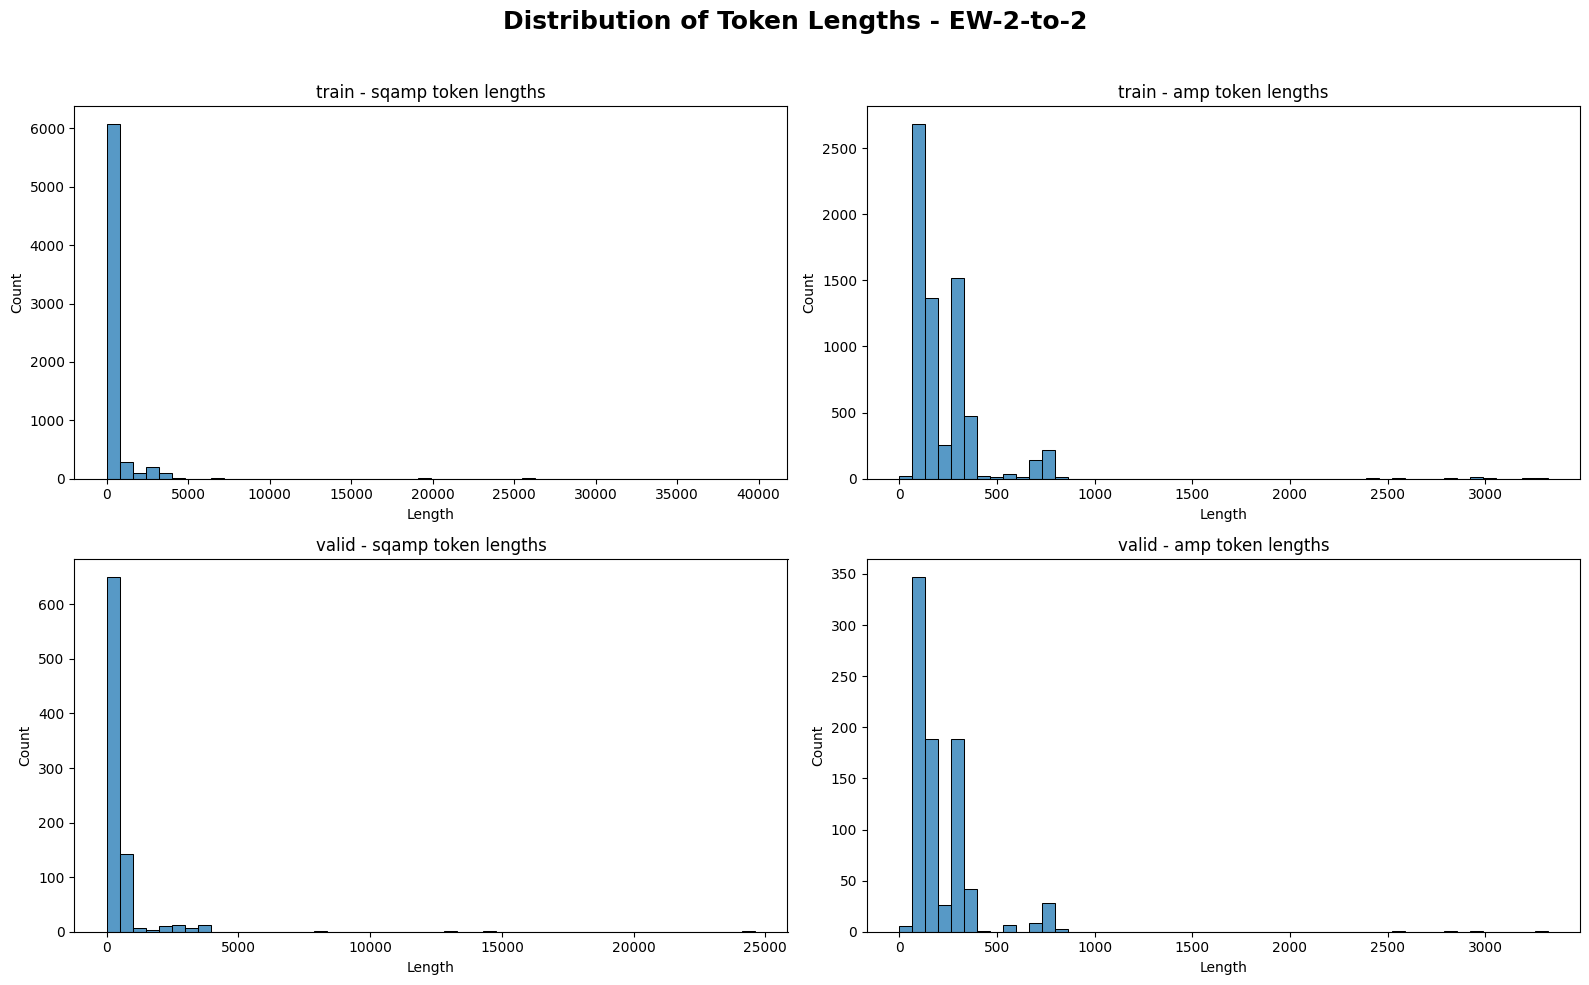


Processing split: train

Processing split: valid


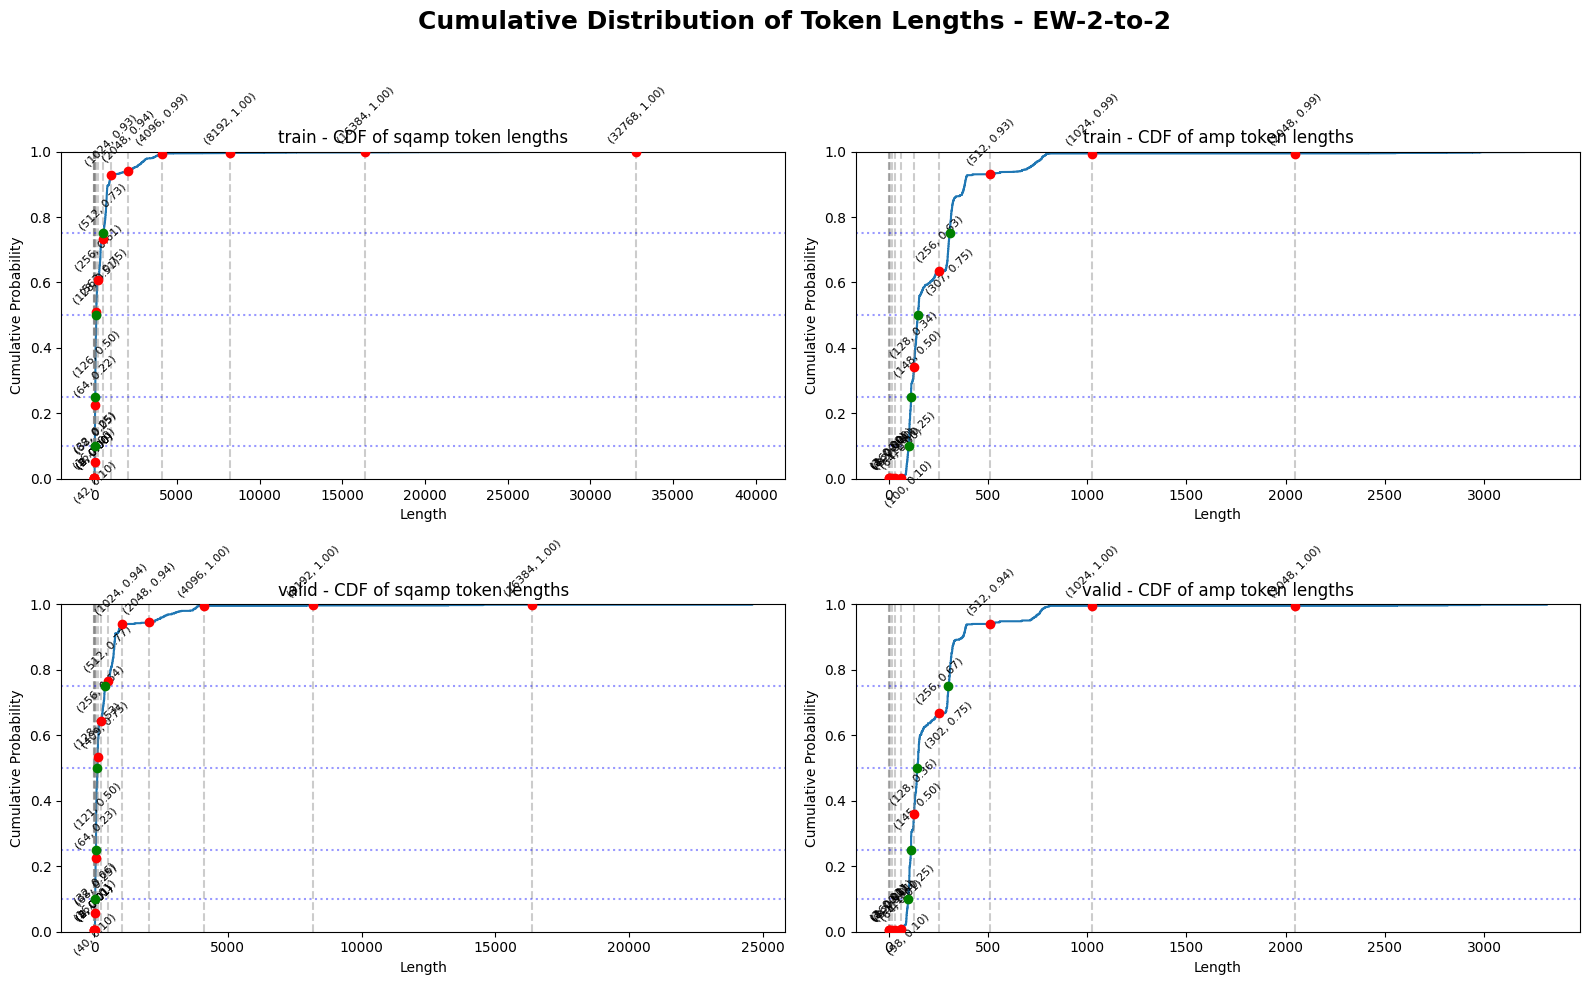

In [ ]:
for data_idx in ew_ids:
    dataset_type = datasets[data_idx]
    print(f"Dataset: {dataset_type}")

    # Load dataset and tokenizer
    src_voc_size, tgt_voc_size, tokenizer, src_vocab, tgt_vocab, df_train, df_valid, df_test = get_df_stats(dataset_type)


    plot_length_dist(dataset_type, src_voc_size, tgt_voc_size, tokenizer, src_vocab, tgt_vocab, df_train, df_valid, df_test)
    get_cum_dist(dataset_type, src_voc_size, tgt_voc_size, tokenizer, src_vocab, tgt_vocab, df_train, df_valid, df_test)
    # break

# More Plots!

Processing dataset: QED-2-to-2
Loaded Dataset


Processing target vocab: 100%|██████████| 360/360 [00:00<00:00, 19383.18it/s]
/tmp/ipykernel_2210350/2858029829.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(avg_lengths.keys()), y=list(avg_lengths.values()), palette="viridis")


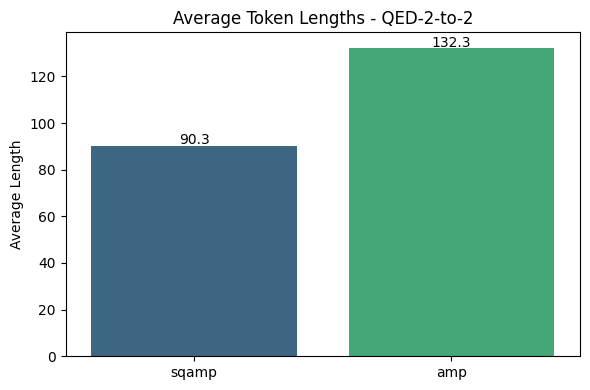

/tmp/ipykernel_2210350/2858029829.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=counts, palette="mako")


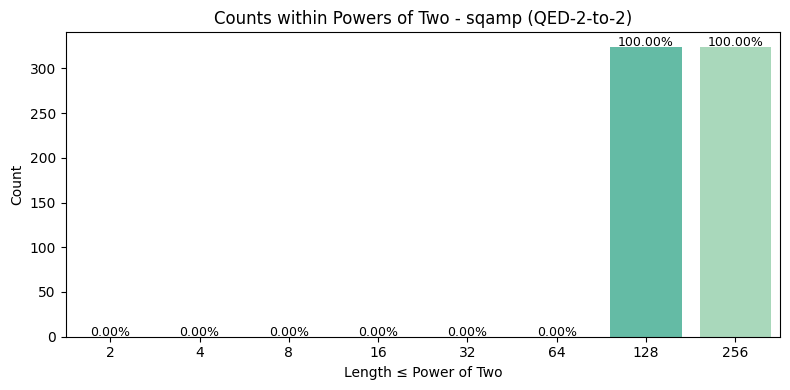

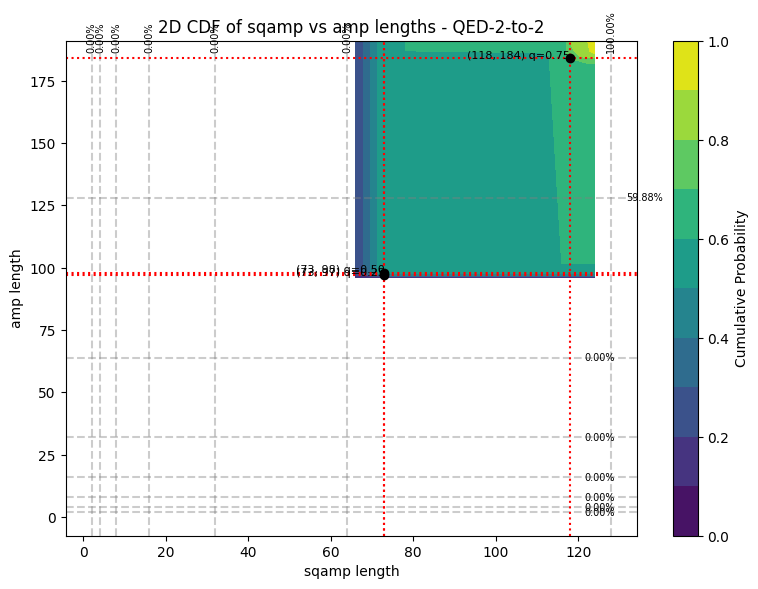

Processing dataset: EW-2-to-3
Loaded Dataset


Processing target vocab: 100%|██████████| 110635/110635 [01:32<00:00, 1190.71it/s]
/tmp/ipykernel_2210350/2858029829.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(avg_lengths.keys()), y=list(avg_lengths.values()), palette="viridis")


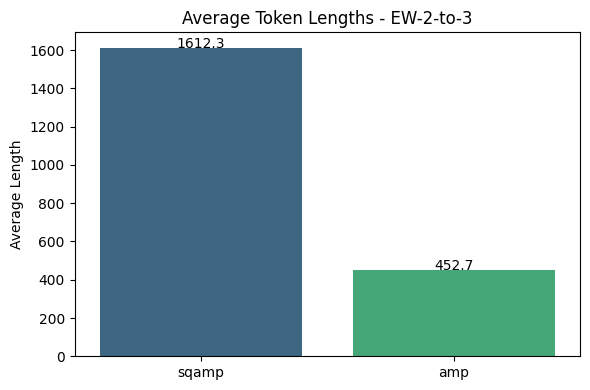

/tmp/ipykernel_2210350/2858029829.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=counts, palette="mako")


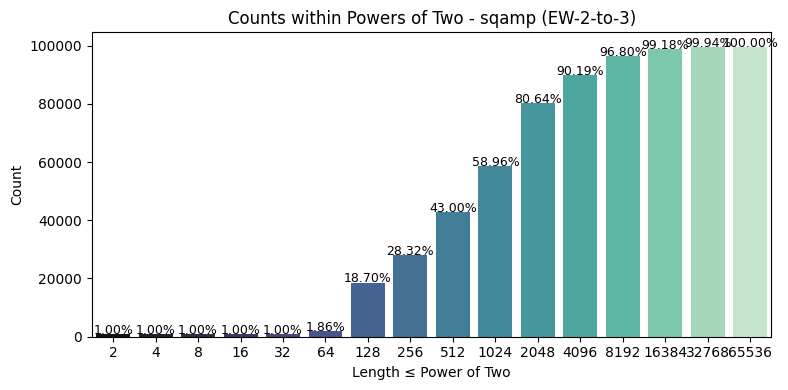

: 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_dataset(dataset_type, tokenizer, df_train, df_valid):
    # Combine train+valid for full analysis
    df_all = pd.concat([df_train, df_valid], ignore_index=True)

    # Tokenize & length calculation
    df_all['sqamp_len'] = df_all['sqamp'].apply(lambda x: len(tokenizer.tgt_tokenize(x)))
    df_all['amp_len']   = df_all['amp'].apply(lambda x: len(tokenizer.src_tokenize(x)))

    sqamp_lengths = df_all['sqamp_len'].values
    amp_lengths   = df_all['amp_len'].values

    # ==== 1. Bar plot of average lengths ====
    avg_lengths = {
        'sqamp': np.mean(sqamp_lengths),
        'amp': np.mean(amp_lengths)
    }

    plt.figure(figsize=(6, 4))
    sns.barplot(x=list(avg_lengths.keys()), y=list(avg_lengths.values()), palette="viridis")
    plt.title(f"Average Token Lengths - {dataset_type}")
    plt.ylabel("Average Length")
    for i, v in enumerate(avg_lengths.values()):
        plt.text(i, v + 0.5, f"{v:.1f}", ha='center', fontsize=10)
    plt.tight_layout()
    plt.show()

    # ==== 2. Powers-of-two bucket counts & fractions ====
    max_len = max(sqamp_lengths.max(), amp_lengths.max())
    bins = [2**i for i in range(1, int(np.log2(max_len)) + 2)]

    counts = []
    fractions = []
    labels = []
    for b in bins:
        c = np.sum(sqamp_lengths <= b)
        counts.append(c)
        fractions.append(c / len(sqamp_lengths))
        labels.append(str(b))

    plt.figure(figsize=(8, 4))
    sns.barplot(x=labels, y=counts, palette="mako")
    plt.title(f"Counts within Powers of Two - sqamp ({dataset_type})")
    plt.ylabel("Count")
    plt.xlabel("Length ≤ Power of Two")
    for i, v in enumerate(fractions):
        plt.text(i, counts[i] + 1, f"{v:.2%}", ha='center', fontsize=9)
    plt.tight_layout()
    plt.show()

    # ==== 3. 2D Cumulative Distribution ====
    # Compute ECDF grid
    x_sorted = np.sort(sqamp_lengths)
    y_sorted = np.sort(amp_lengths)
    X, Y = np.meshgrid(x_sorted, y_sorted)
    Z = np.array([
        np.mean((sqamp_lengths <= x) & (amp_lengths <= y))
        for x, y in zip(np.ravel(X), np.ravel(Y))
    ]).reshape(X.shape)

    fig, ax = plt.subplots(figsize=(8, 6))
    cs = ax.contourf(X, Y, Z, levels=np.linspace(0, 1, 11), cmap="viridis")
    cbar = plt.colorbar(cs, ax=ax)
    cbar.set_label("Cumulative Probability")

    ax.set_title(f"2D CDF of sqamp vs amp lengths - {dataset_type}")
    ax.set_xlabel("sqamp length")
    ax.set_ylabel("amp length")

    # Mark powers of two
    pows = [2**i for i in range(1, int(np.log2(max_len)) + 1)]
    for p in pows:
        ax.axvline(p, color='gray', linestyle='--', alpha=0.4)
        ax.axhline(p, color='gray', linestyle='--', alpha=0.4)
        prob_x = np.mean(sqamp_lengths <= p)
        prob_y = np.mean(amp_lengths <= p)
        ax.text(p, ax.get_ylim()[1]*0.98, f"{prob_x:.2%}", rotation=90, fontsize=7, ha='center')
        ax.text(ax.get_xlim()[1]*0.98, p, f"{prob_y:.2%}", fontsize=7, va='center')

    # Mark quantiles
    for q in [0.25, 0.5, 0.75]:
        qx = np.percentile(sqamp_lengths, q*100)
        qy = np.percentile(amp_lengths, q*100)
        ax.axvline(qx, color='red', linestyle=':')
        ax.axhline(qy, color='red', linestyle=':')
        ax.scatter(qx, qy, color='black', zorder=5)
        ax.text(qx, qy, f"({int(qx)}, {int(qy)}) q={q:.2f}", fontsize=8, ha='right')

    plt.tight_layout()
    plt.show()


# ==== Example loop ====
for dataset_type in datasets:
    if 'sinekan' in dataset_type:
        continue
    print(f"Processing dataset: {dataset_type}")
    src_voc_size, tgt_voc_size, tokenizer, src_vocab, tgt_vocab, df_train, df_valid, df_test = get_df_stats(dataset_type)
    analyze_dataset(dataset_type, tokenizer, df_train, df_valid)


# Length based Retention

In [11]:
ew_ids = []
for i,d  in enumerate(datasets):
    if 'EW' in d:
        ew_ids.append(i)

ew_ids

[2, 4]

In [35]:
# for data_idx in ew_ids:
dataset_type = datasets[4]
print(f"Dataset: {dataset_type}")

# Load dataset and tokenizer
src_voc_size, tgt_voc_size, tokenizer, src_vocab, tgt_vocab, df_train, df_valid, df_test = get_df_stats(dataset_type)

# break

Dataset: EW-2-to-2
Loaded Dataset


Processing source vocab:   8%|▊         | 662/8512 [00:00<00:01, 6613.78it/s]

Processing target vocab: 100%|██████████| 8512/8512 [00:02<00:00, 4202.42it/s]


In [36]:
%%time
df_train['sqamp_tokens'] = df_train['sqamp'].apply(tokenizer.tgt_tokenize)
df_train['amp_tokens'] = df_train['amp'].apply(tokenizer.src_tokenize)


CPU times: user 2.46 s, sys: 4.01 ms, total: 2.47 s
Wall time: 2.47 s


In [37]:
%%time
df_train['sqamp_tokens'] = df_train['sqamp_tokens'].apply(len)
df_train['amp_tokens'] = df_train['amp_tokens'].apply(len)

CPU times: user 33.7 ms, sys: 3.89 ms, total: 37.6 ms
Wall time: 36.7 ms


In [38]:
sls = list(df_train['sqamp_tokens'])
als = list(df_train['amp_tokens'])

In [ ]:
amax = 512
smax = 1024

def count(als, sls, a_max, b_max):
    su =  sum([1 for a,b in zip(als, sls) if a <= a_max and b <= b_max])
    return su, su/ len(als)

In [43]:
%%time
count(als, sls, 512, 2048)

CPU times: user 423 μs, sys: 20 μs, total: 443 μs
Wall time: 448 μs


(6335, 0.9303862534880305)

# PAD CHECK

# Misc

Dataset: QED-2-to-2
Loaded Dataset


Processing target vocab: 100%|██████████| 360/360 [00:00<00:00, 20165.19it/s]


Processing split: train


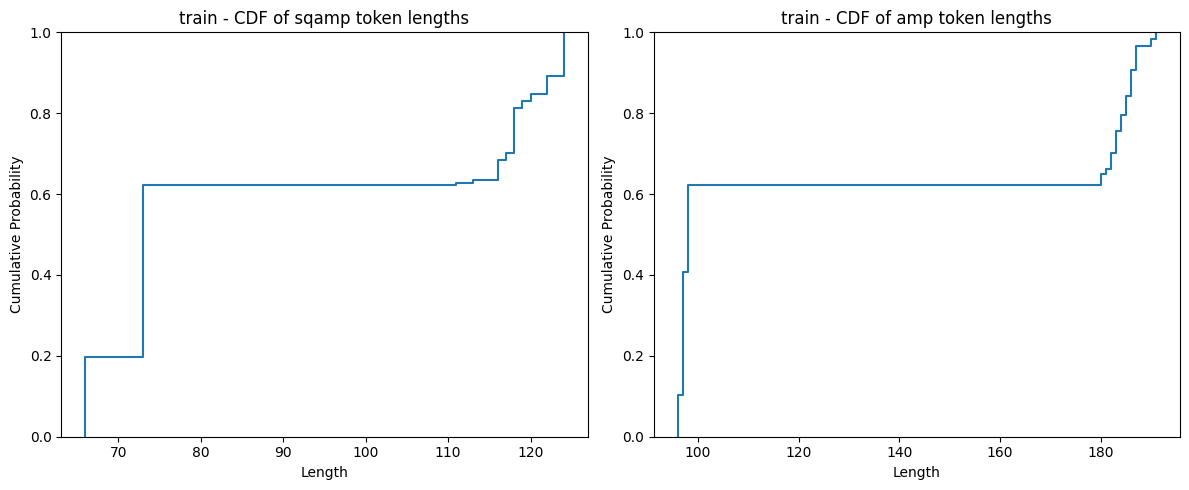


Processing split: valid


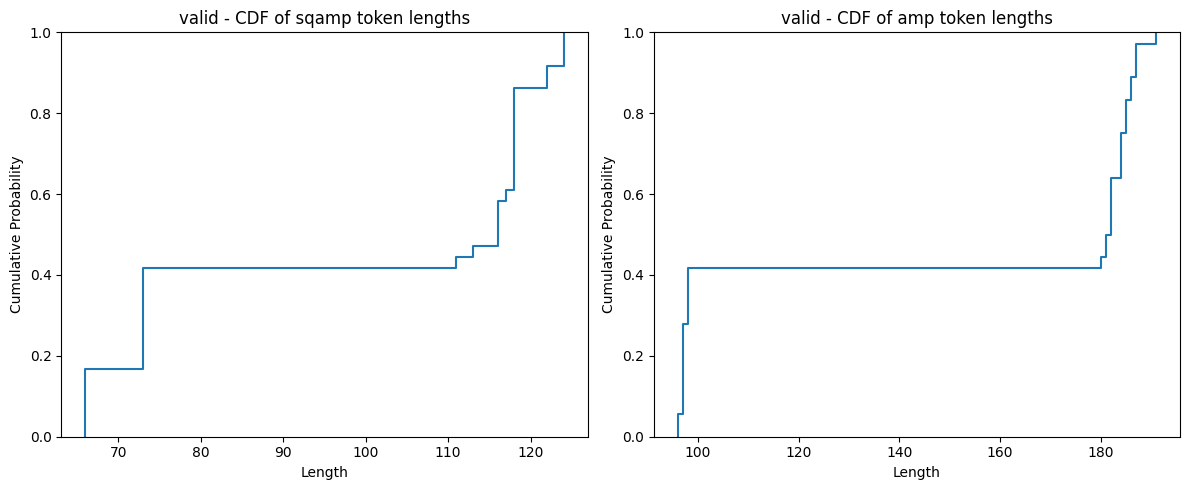

CPU times: user 706 ms, sys: 681 ms, total: 1.39 s
Wall time: 662 ms


In [12]:
%%time
plot_idx(0)

Dataset: EW-2-to-3


Loaded Dataset


Processing target vocab: 100%|██████████| 110635/110635 [01:24<00:00, 1303.92it/s]



Processing split: train


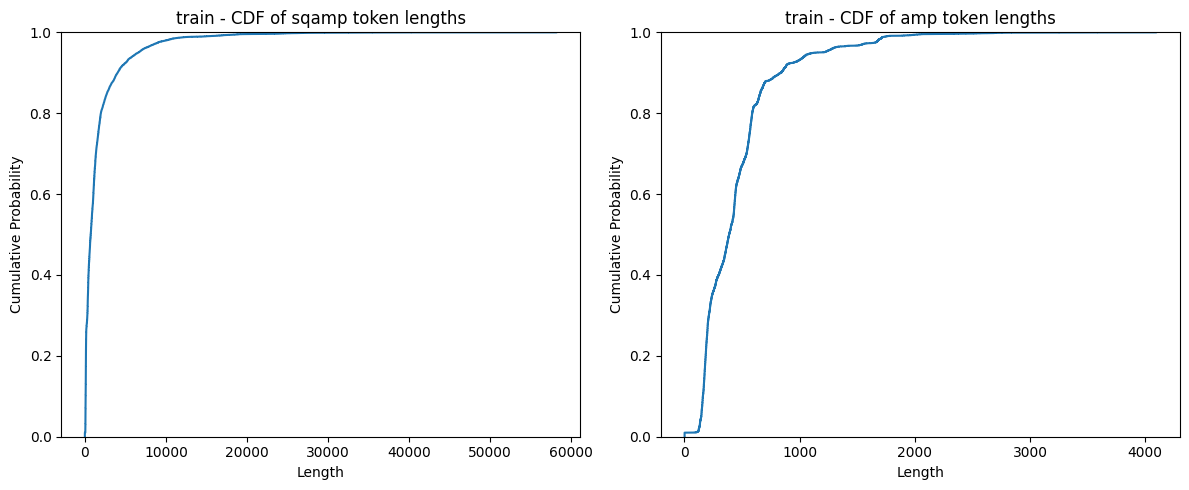


Processing split: valid


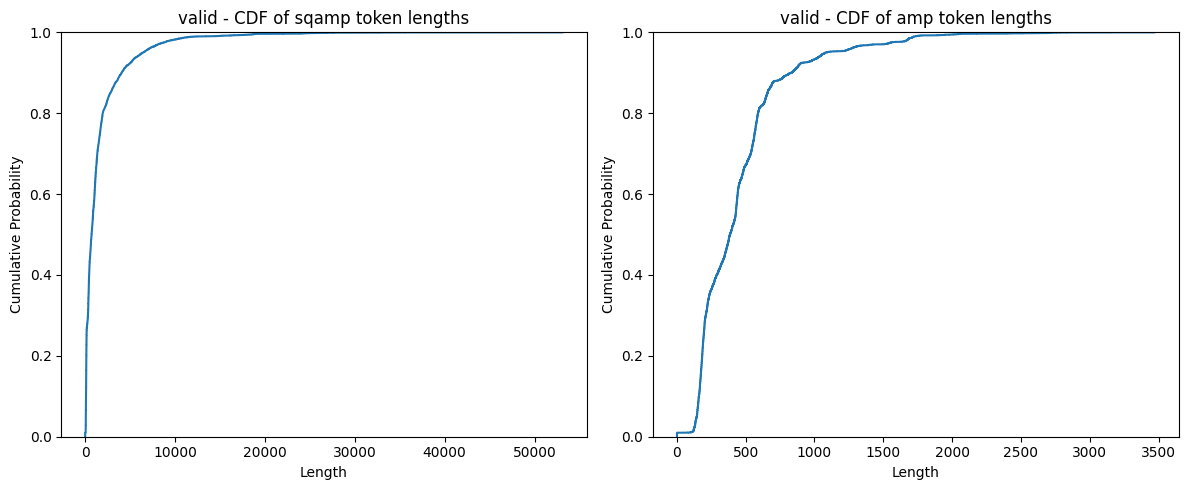

CPU times: user 3min 45s, sys: 5.79 s, total: 3min 51s
Wall time: 3min 50s


In [13]:
%%time
plot_idx(1)

Dataset: QED-2-to-3
Loaded Dataset


Processing source vocab:  18%|█▊        | 534/3042 [00:00<00:00, 2609.56it/s]

Processing target vocab: 100%|██████████| 3042/3042 [00:02<00:00, 1346.30it/s]



Processing split: train


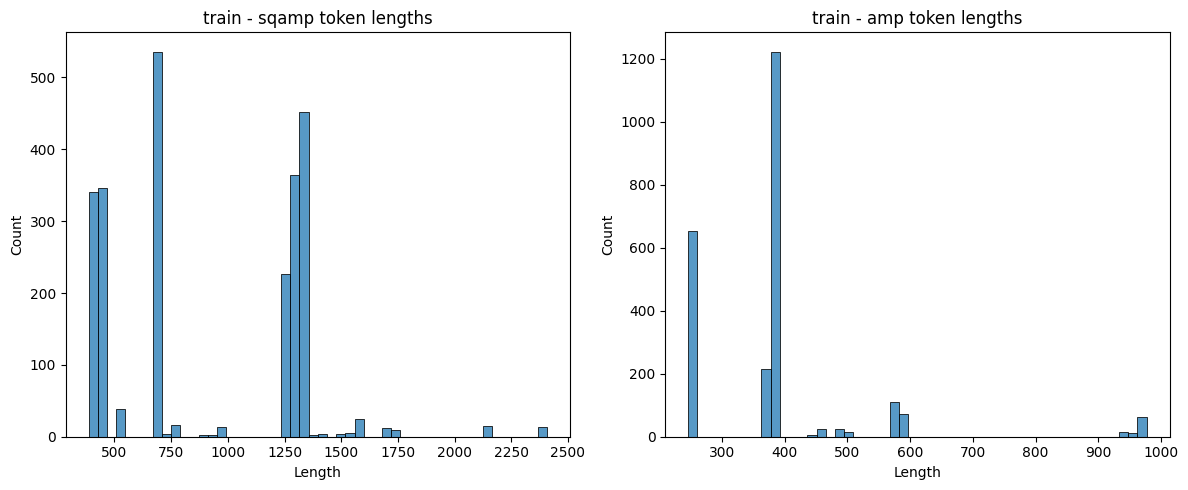


Processing split: valid


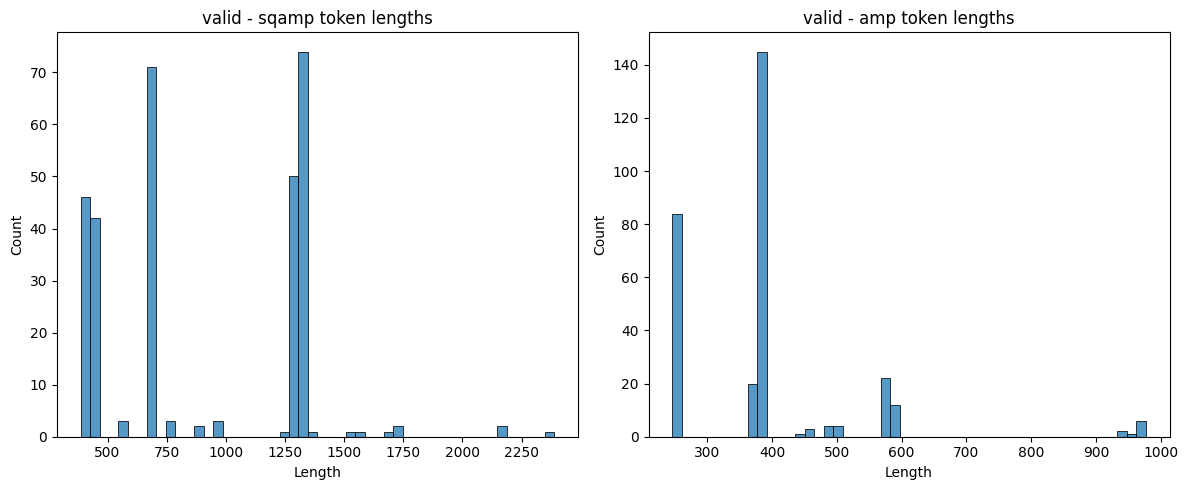

CPU times: user 7.19 s, sys: 1.03 s, total: 8.22 s
Wall time: 7.5 s


In [15]:
%%time
plot_idx(2)

Dataset: EW-2-to-2
Loaded Dataset


Processing target vocab: 100%|██████████| 8512/8512 [00:03<00:00, 2452.62it/s]



Processing split: train


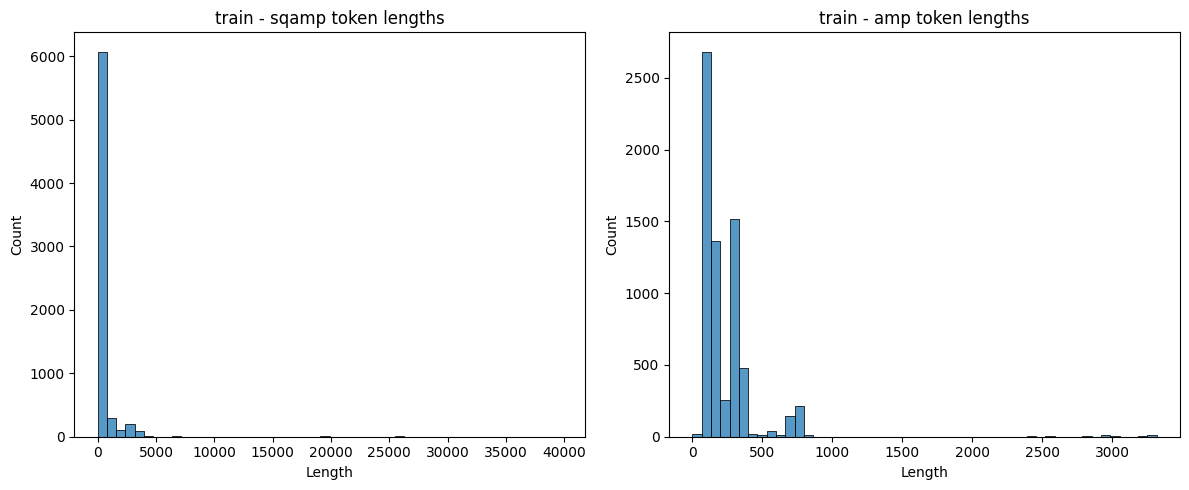


Processing split: valid


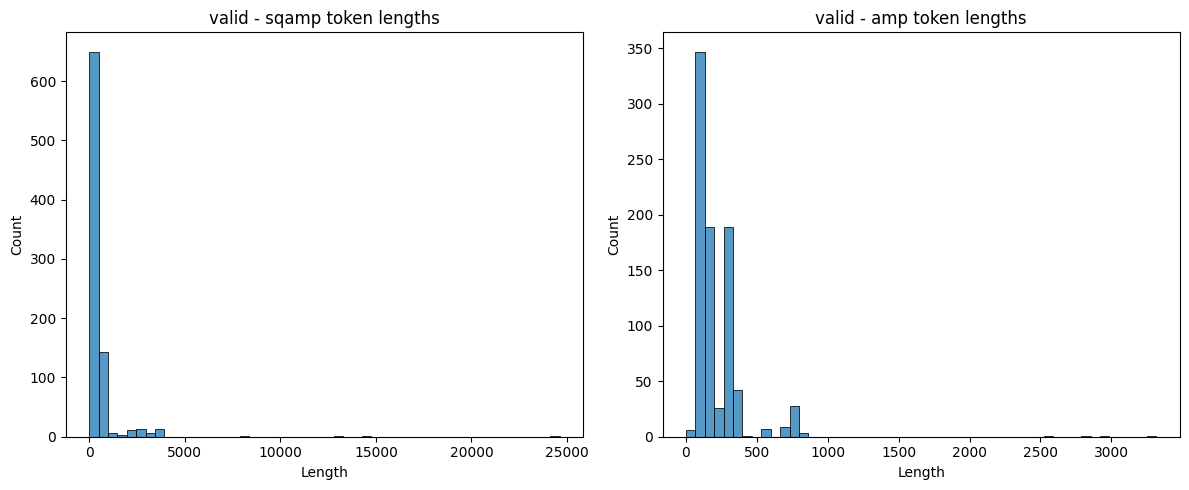

CPU times: user 10.6 s, sys: 1.24 s, total: 11.9 s
Wall time: 11.1 s


In [16]:
%%time
plot_idx(3)

Dataset: QED-2-to-4
Loaded Dataset


Processing target vocab: 100%|██████████| 20762/20762 [01:09<00:00, 297.77it/s]



Processing split: train


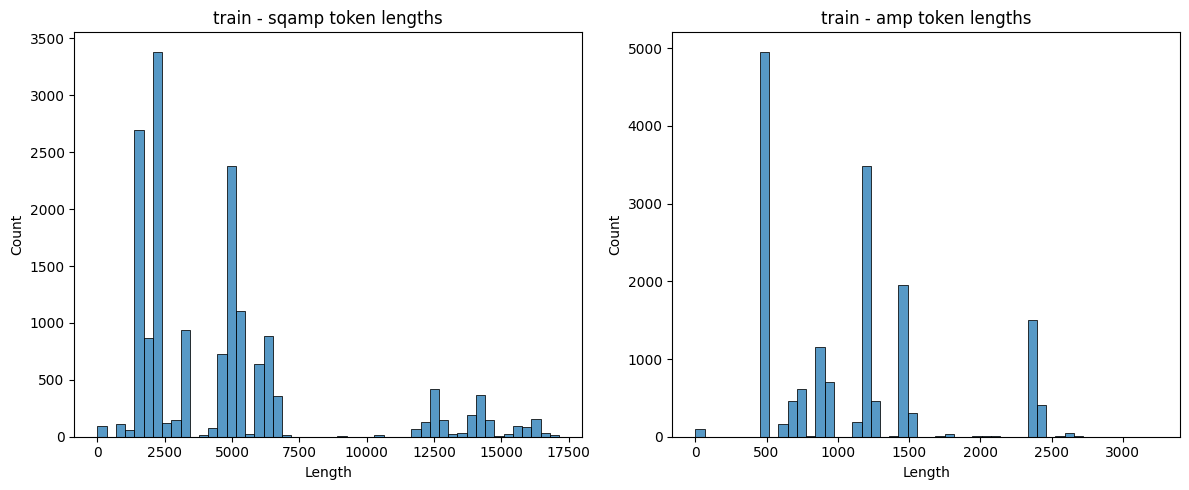


Processing split: valid


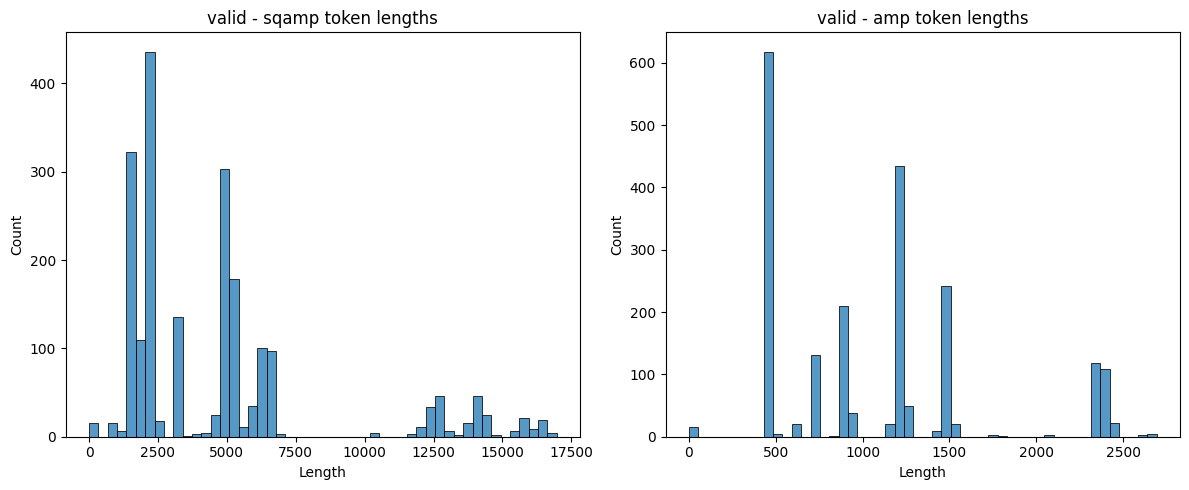

CPU times: user 2min 43s, sys: 6.35 s, total: 2min 49s
Wall time: 2min 51s


In [17]:
%%time
plot_idx(4)

Dataset: QCD-2-to-2
Loaded Dataset


Processing target vocab: 100%|██████████| 234/234 [00:00<00:00, 2636.20it/s]


Processing split: train


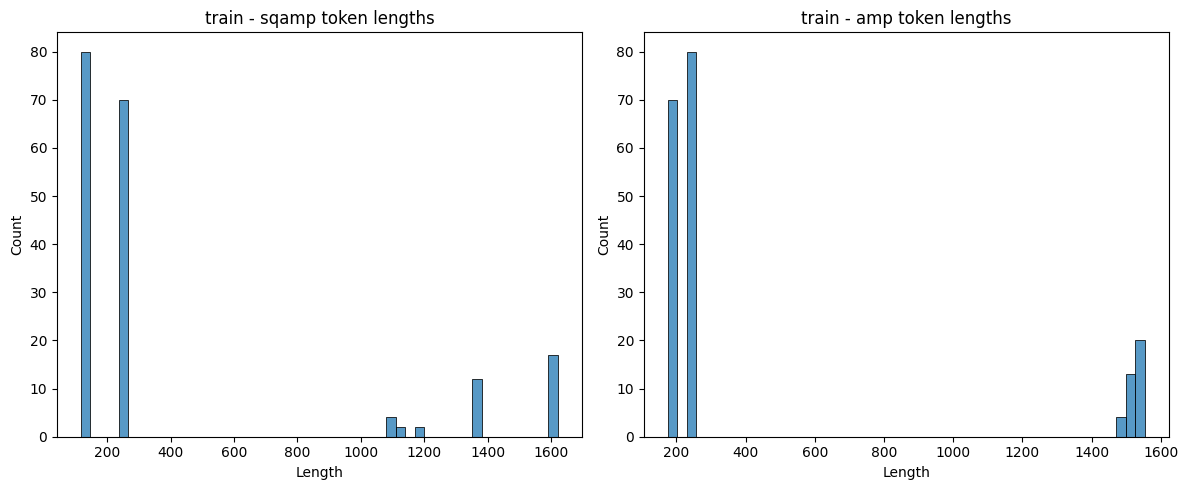


Processing split: valid


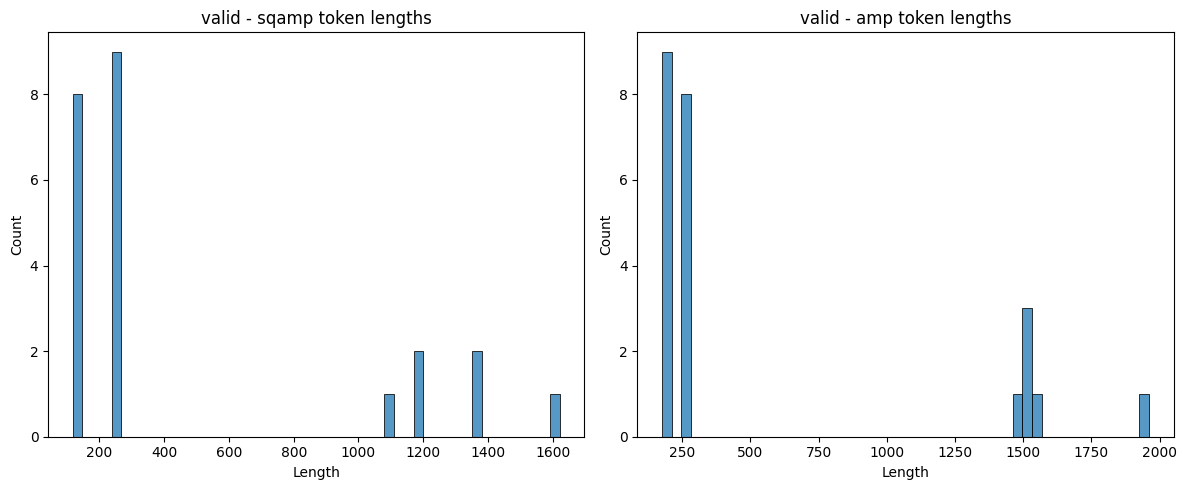

CPU times: user 1.58 s, sys: 890 ms, total: 2.47 s
Wall time: 1.54 s


In [19]:
%%time
plot_idx(5)

Dataset: QCD-2-to-3
Loaded Dataset


Processing target vocab: 100%|██████████| 1518/1518 [00:03<00:00, 388.85it/s]



Processing split: train


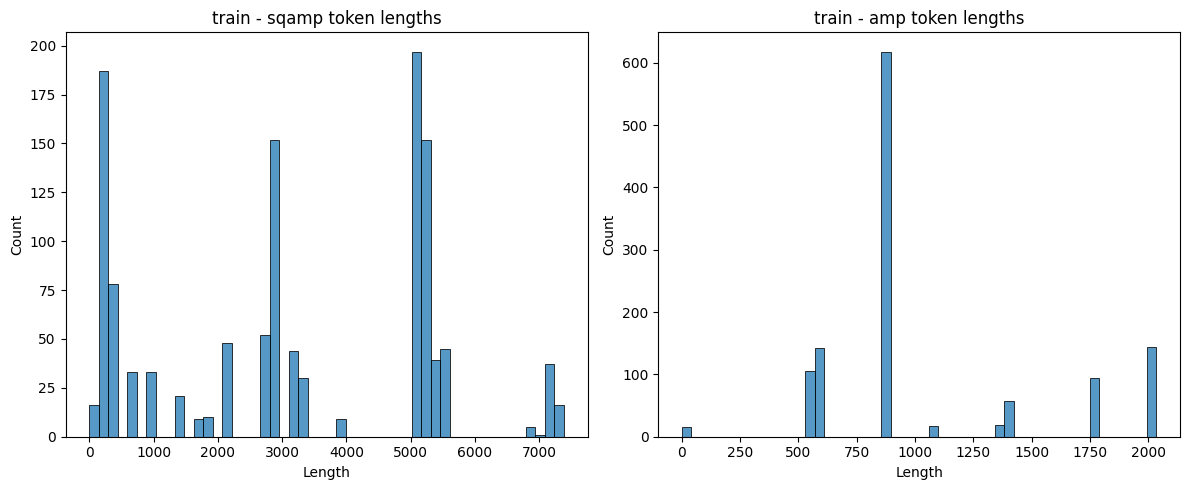


Processing split: valid


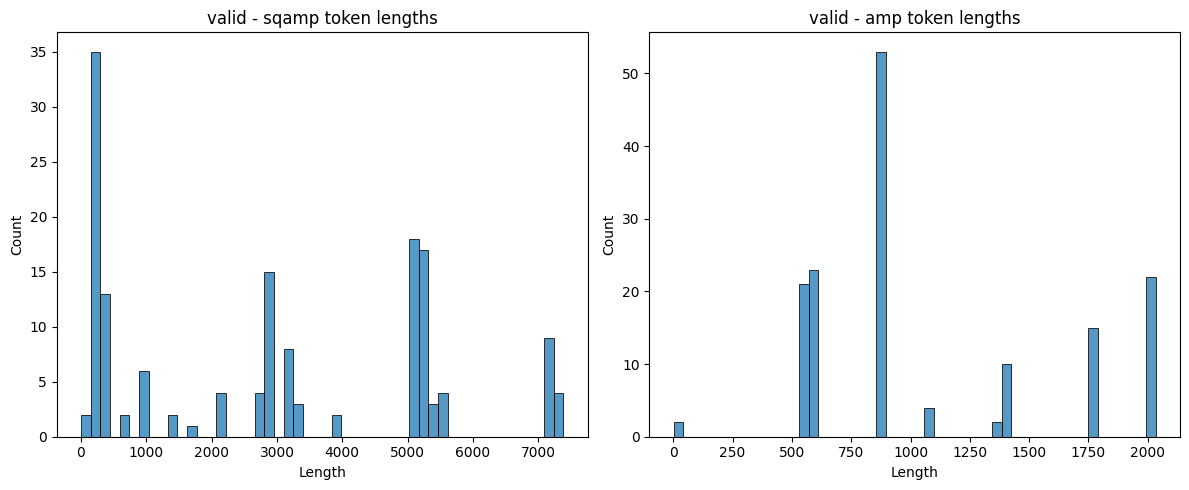

CPU times: user 10.7 s, sys: 1.27 s, total: 12 s
Wall time: 11.3 s


In [20]:
%%time
plot_idx(6)

Dataset: QCD-2-to-4


Loaded Dataset


Processing target vocab: 100%|██████████| 2385/2385 [00:21<00:00, 109.41it/s]



Processing split: train


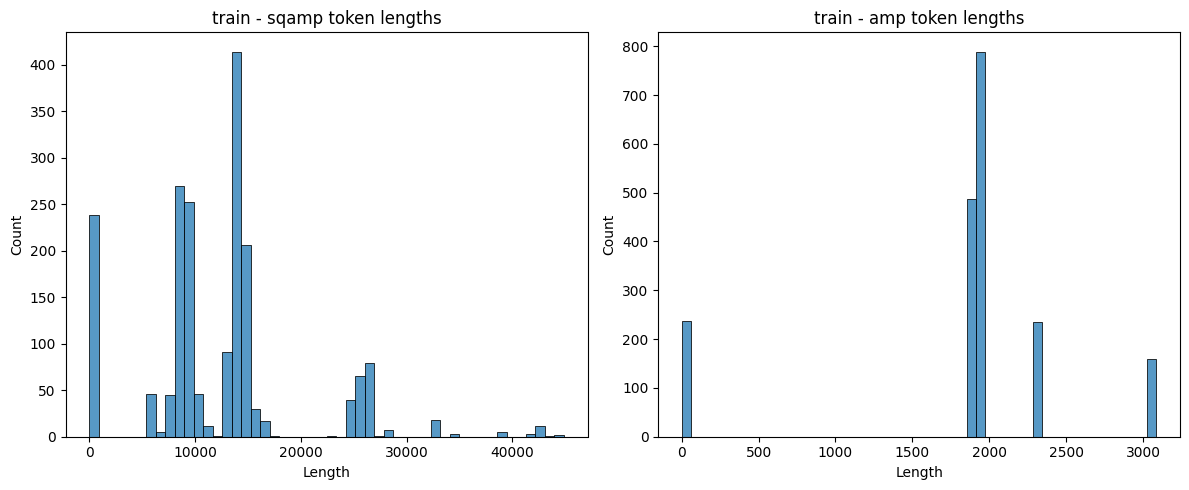


Processing split: valid


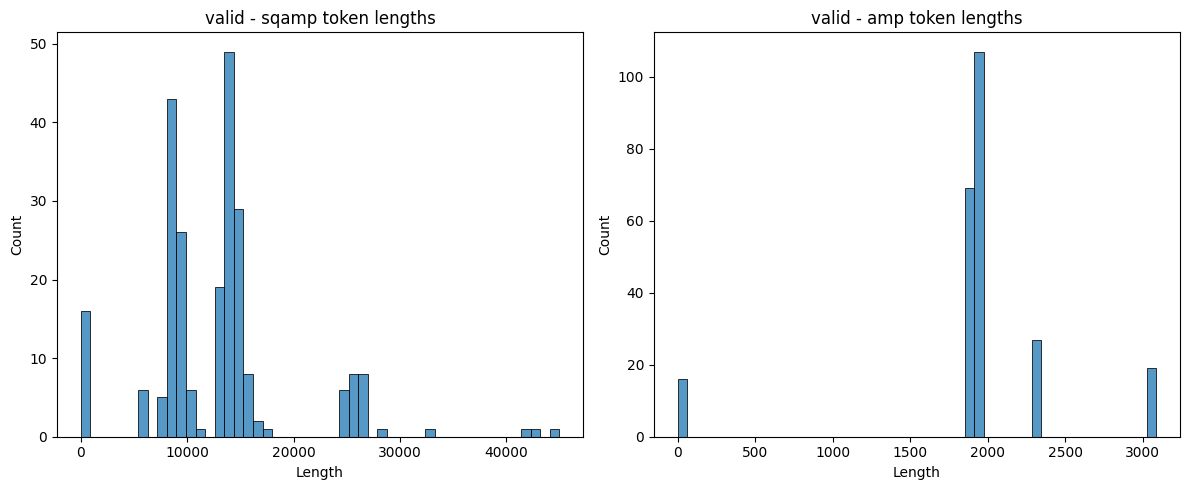

CPU times: user 48.8 s, sys: 2.57 s, total: 51.4 s
Wall time: 51.6 s


In [22]:
%%time
plot_idx(7)

In [ ]:
data_idx = 3
dataset_type = datasets[data_idx]
print(dataset_type)

EW-2-to-2


In [12]:
src_voc_size, tgt_voc_size, tokenizer, src_vocab, tgt_vocab, df_train, df_valid, df_test = get_df(dataset_type)

didx = 0
df_tup = (df_train, df_valid, df_test)

df_c = df_tup[didx]

Loaded Dataset


Processing source vocab:   8%|▊         | 645/8512 [00:00<00:01, 6444.31it/s]

Processing target vocab: 100%|██████████| 8512/8512 [00:02<00:00, 4216.65it/s]


In [13]:
# df_c['sqamp'].str.len().max()
df_trimmed = df_c[
                (df_c['sqamp'].apply(tokenizer.tgt_tokenize).str.len() <= 512) &
                (df_c['amp'].apply(tokenizer.src_tokenize).str.len() <= 512)
            ].reset_index(drop=True)
# df_trimmed['sqamp'].str.len().max()


In [27]:
len(tokenizer.tgt_tokenize(df_trimmed.iloc[79]['sqamp']))

510

In [14]:
len(df_trimmed)

4988

In [25]:
df_c['sqamp'][:1].apply(tokenizer.tgt_tokenize).str.len()

0    3098
Name: sqamp, dtype: int64

In [30]:
len(df_c['sqamp'][:1].apply(tokenizer.tgt_tokenize)[0])

3098

In [18]:
from tqdm.auto import tqdm
slens = []
tlens = []

for idx in tqdm(range(len(df_trimmed))):

    src_val = df_trimmed['amp'][idx]
    tgt_val = df_trimmed['sqamp'][idx]
    # print(len(src_val))
    src_tokenized = tokenizer.src_tokenize(src_val)
    tgt_tokenized = tokenizer.tgt_tokenize(tgt_val)
    src_ids = src_vocab.encode(src_tokenized)
    tgt_ids = tgt_vocab.encode(tgt_tokenized)
    # print(src_tokenized)
    # print(src_ids)
    # assert len(src_ids) != len(src_tokenized)
    slens.append((len(src_ids), len(str(src_val)) ))
    tlens.append((len(tgt_ids), len(str(tgt_val)) ))
    assert len(src_ids) <= 512, len(src_ids)
    assert len(tgt_ids) <= 512, len(tgt_ids)
    print(len(src_ids), len(tgt_ids))
    break
# slens, tlens

  0%|          | 0/4988 [00:00<?, ?it/s]

112 30


In [ ]:

# src_ids = self.src_vocab.encode(src_tokenized)
# tgt_ids = self.tgt_vocab.encode(tgt_tokenized)

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Plot slens
sns.histplot(slens, color='blue', label='Source Lengths', kde=True, stat='density', bins=30)
# Plot tlens
sns.histplot(tlens, color='orange', label='Target Lengths', kde=True, stat='density', bins=30)

plt.xscale("log")

plt.title("Distribution of Tokenized Lengths")
plt.xlabel("Sequence Length")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7f8796106290> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

4098

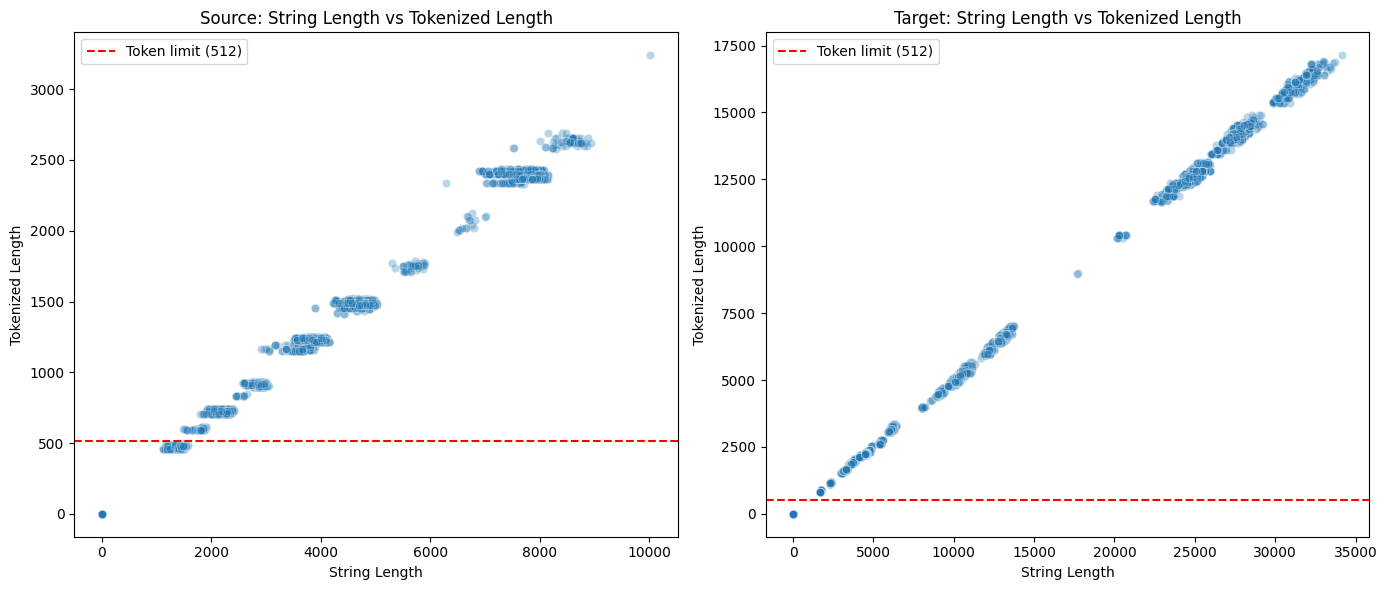

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Unzip tuple lists into two separate lists
src_token_lens, src_str_lens = zip(*slens)
tgt_token_lens, tgt_str_lens = zip(*tlens)

# Plot relationship between string length and tokenized length
plt.figure(figsize=(14, 6))

# Source plot
plt.subplot(1, 2, 1)
sns.scatterplot(x=src_str_lens, y=src_token_lens, alpha=0.3)
plt.axhline(512, color='red', linestyle='--', label='Token limit (512)')
plt.title("Source: String Length vs Tokenized Length")
plt.xlabel("String Length")
plt.ylabel("Tokenized Length")
plt.legend()

# Target plot
plt.subplot(1, 2, 2)
sns.scatterplot(x=tgt_str_lens, y=tgt_token_lens, alpha=0.3)
plt.axhline(512, color='red', linestyle='--', label='Token limit (512)')
plt.title("Target: String Length vs Tokenized Length")
plt.xlabel("String Length")
plt.ylabel("Tokenized Length")
plt.legend()

plt.tight_layout()
plt.show()


In [24]:
import numpy as np

def find_threshold(str_lens, token_lens, token_limit=512):
    str_lens = np.array(str_lens)
    token_lens = np.array(token_lens)
    valid = token_lens <= token_limit
    max_valid_str_len = str_lens[valid].max()
    return max_valid_str_len

src_threshold = find_threshold(src_str_lens, src_token_lens)
tgt_threshold = find_threshold(tgt_str_lens, tgt_token_lens)

print(f"Max source string length for tokenized length <= 512: {src_threshold}")
print(f"Max target string length for tokenized length <= 512: {tgt_threshold}")


Max source string length for tokenized length <= 512: 1574
Max target string length for tokenized length <= 512: 24
